# Import librairies

In [18]:
import pandas as pd, numpy as np, seaborn as sns, warnings, os
from datetime import datetime as dt
from matplotlib import pyplot as plt

import matplotlib.font_manager as fm
import plotly.express as px
import plotly.graph_objs as go

font1 = fm.FontProperties(size=20)
font2 = fm.FontProperties(size=24)

warnings.filterwarnings(action="ignore")

if int(str(sns.__version__).split('.')[1]) > 8 : 
    plt.style.use('seaborn-v0_8-darkgrid')
else:
    plt.style.use('seaborn-darkgrid')
sns.set(font_scale=3)

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans

# Outils

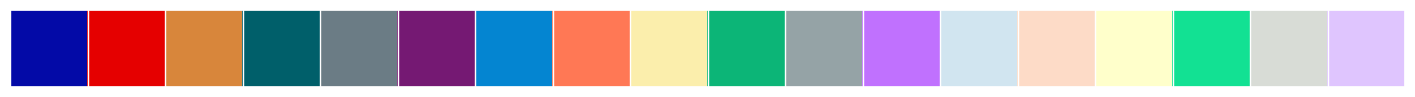

In [20]:
palette = [ "#030aa7", "#e50000", "#d8863b", "#005f6a", "#6b7c85", "#751973", 
            "#0485d1", "#ff7855", "#fbeeac", "#0cb577", "#95a3a6", "#c071fe", 
            "#d1e5f0", "#fddbc7", "#ffffcb", "#12e193", "#d8dcd6", "#dfc5fe", 
          ]
sns.palplot(sns.color_palette(palette))

In [21]:
repertoireRacine  = '.'
nomProjet         = 'ConsolidationDonneesMeteo'

repertoireProjet  = os.path.join(repertoireRacine, nomProjet)
repertoireDonnees = os.path.join(repertoireProjet, 'repertoire.donnees')
repertoireImages  = os.path.join(repertoireProjet, 'repertoire.images')


def controleExistenceRepertoire( repertoire, create_if_needed=True):
    """Voir si le répertoire existe. S'il n'existe pas il est créé."""
    path_exists = os.path.exists(repertoire)
    if path_exists:
        if not os.path.isdir(repertoire):
            raise Exception("Trouvé le nom  "+repertoire +" mais c'est un fichier, pas un répertoire")
            # return False
        return True
    if create_if_needed:
        os.makedirs(repertoire)

def sauvegarderImage( fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    controleExistenceRepertoire(repertoireImages)
    plt.savefig(os.path.join(repertoireImages,
                             fichier+f"--{dt.now().strftime('%Y_%m_%d_%H.%M.%S')}.png"), 
                             dpi=600, 
                             bbox_inches='tight')

def sauvegarderImageSNS( sns_plot, fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    controleExistenceRepertoire(repertoireImages)
    fig = sns_plot.get_figure()
    fig.savefig(os.path.join(repertoireImages,fichier+'.png'))
    
controleExistenceRepertoire(repertoireProjet);
controleExistenceRepertoire(repertoireDonnees);
controleExistenceRepertoire(repertoireImages);

In [22]:
donnees = pd.read_parquet('../donnees/donnees_meteo.gzip')
donnees.set_index(['Nom', 'Latitude', 'Longitude', 'Altitude', 'Zone'],inplace=True)

In [23]:
donnees[['VitesseVent','Temperature','Humidite','Pression','Visibilite','Precipitation']].head()

VitesseVent  Temperature  \
Nom       Latitude Longitude Altitude Zone                             
Abbeville 50.136   1.834     69       NO            2.0         2.89   
                                      NO            3.0         2.70   
                                      NO            3.0         2.89   
                                      NO            4.1         3.60   
                                      NO            5.1         4.39   

                                            Humidite  Pression  Visibilite  \
Nom       Latitude Longitude Altitude Zone                                   
Abbeville 50.136   1.834     69       NO        99.0     990.9         NaN   
                                      NO        99.0     990.7         NaN   
                                      NO        99.0     990.9         0.1   
                                      NO        99.0     991.1         0.8   
                                      NO        99.0     990.4         1.6   

                                            Precipitation  
Nom       Latitude Longitude Altitude Zone                 
Abbeville 50.136   1.834     69       NO              0.0  
                                      NO              0.2  
                                      NO              0.0  
                                      NO              0.0  
                                      NO              0.0

In [24]:
donnees.Annee.min(),donnees.Annee.max()

(np.int32(1996), np.int32(2025))

# Moyenne mensuelle par ville  

In [25]:
donneesM = donnees.reset_index().pivot_table(index=['Nom', 'Latitude', 'Longitude', 'Altitude', 'Zone'],
                                 columns='Mois',
                                 values=['VitesseVent','Temperature','Humidite','Pression','Visibilite','Precipitation'],  
                                 aggfunc = 'mean',
                                 sort = False)
donneesM.columns=[f'{column[0]}{column[1]:02d}' for column in donneesM.columns]
donneesM.to_parquet(os.path.join(repertoireDonnees,'donneesM.gzip'),compression='gzip', engine='pyarrow') 
donneesM.head()

,,,,,VitesseVent01,VitesseVent02,VitesseVent03,VitesseVent04,VitesseVent05,VitesseVent06,VitesseVent07,VitesseVent08,VitesseVent09,VitesseVent10,...,Precipitation03,Precipitation04,Precipitation05,Precipitation06,Precipitation07,Precipitation08,Precipitation09,Precipitation10,Precipitation11,Precipitation12
Nom,Latitude,Longitude,Altitude,Zone,,,,,,,,,,,,,,,,,,,,,
Abbeville,50.136000,1.834000,69,NO,4.753715,4.980679,4.677836,4.228695,4.146520,3.816119,3.882559,3.683411,3.656515,4.086500,...,0.215266,0.196593,0.230670,0.242570,0.252919,0.335974,0.258719,0.325105,0.385547,0.335048
Lille,50.570000,3.097500,47,NE,4.894924,5.091162,4.656690,4.213438,4.129579,3.831556,3.836473,3.588524,3.684030,4.164421,...,0.216363,0.178654,0.244884,0.256846,0.255576,0.301552,0.221778,0.284485,0.320859,0.274807
Pte De La Hague,49.725167,-1.939833,6,NO,8.684824,8.523110,7.449200,6.537055,6.185750,5.694469,5.608665,5.833037,6.756190,7.833829,...,0.231237,0.164812,0.177204,0.159730,0.150402,0.194872,0.209979,0.390612,0.417336,0.406932
Caen,49.180000,-0.456167,67,NO,5.084099,5.220249,4.662767,4.135139,3.962349,3.673348,3.911550,3.840823,3.884973,4.362191,...,0.201414,0.203004,0.235352,0.236995,0.195375,0.236854,0.215262,0.324070,0.339012,0.314534
Rouen,49.383000,1.181667,151,NO,4.688857,4.825871,4.539636,4.149957,3.988098,3.663201,3.672504,3.474372,3.665704,4.191198,...,0.235533,0.206567,0.248620,0.264754,0.240129,0.256897,0.230274,0.334298,0.348440,0.398921


In [26]:
plt.figure(figsize=(96,96))
sns.set(font_scale=3)
plt.title('Correlation Pearson des variables', y=1.05, size=56)
sns.heatmap(donneesM.corr(),linewidths=0.3, #vmax=1.0, fmt= '.2f', 
            square=True, cmap='coolwarm', linecolor='white', annot=False)
sauvegarderImage('Correlation Pearson des variables--DonneesM')
sns.set(font_scale=2)

# Moyenne journalière  par ville

In [27]:
donneesJ = donnees.reset_index().pivot_table(index=['Nom', 'Latitude', 'Longitude', 'Altitude', 'Zone'],
                                 columns='Jour',
                                 values=['VitesseVent','Temperature','Humidite','Pression','Visibilite','Precipitation'],  
                                 aggfunc = 'mean',
                                 sort = False)

donneesJ.columns=[f'{column[0]}{column[1]:03d}' for column in donneesJ.columns]
donneesJ.to_parquet(os.path.join(repertoireDonnees,'donneesJ.gzip'),compression='gzip', engine='pyarrow') 
donneesJ.head()

,,,,,VitesseVent001,VitesseVent002,VitesseVent003,VitesseVent004,VitesseVent005,VitesseVent006,VitesseVent007,VitesseVent008,VitesseVent009,VitesseVent010,...,Precipitation357,Precipitation358,Precipitation359,Precipitation360,Precipitation361,Precipitation362,Precipitation363,Precipitation364,Precipitation365,Precipitation366
Nom,Latitude,Longitude,Altitude,Zone,,,,,,,,,,,,,,,,,,,,,
Abbeville,50.136000,1.834000,69,NO,4.367500,4.742917,5.227848,5.301250,4.965833,4.074167,4.717500,4.931667,4.866250,4.079167,...,0.434664,0.347458,0.376360,0.537342,0.337395,0.315042,0.250211,0.317437,0.205649,0.130435
Lille,50.570000,3.097500,47,NE,5.077872,5.202991,5.616596,5.385345,5.111159,4.481385,5.302597,5.266379,5.257576,4.325862,...,0.337866,0.361765,0.345397,0.403992,0.324160,0.407353,0.255252,0.214468,0.248750,0.070423
Pte De La Hague,49.725167,-1.939833,6,NO,9.379821,9.341150,9.733621,8.764224,8.557391,7.891556,9.558294,9.558525,9.041629,8.098206,...,0.455769,0.425210,0.292887,0.386134,0.392469,0.392766,0.441176,0.513261,0.435865,0.264706
Caen,49.180000,-0.456167,67,NO,5.612340,5.490000,5.806667,5.568201,4.925523,4.714644,5.357322,5.448117,5.229707,4.338494,...,0.364435,0.413462,0.309534,0.314916,0.415823,0.372708,0.313808,0.354008,0.251055,0.180556
Rouen,49.383000,1.181667,151,NO,4.761803,5.049153,5.258547,5.131602,4.691810,4.206087,4.984322,5.153556,4.789362,3.961345,...,0.626891,0.481381,0.361345,0.411181,0.523941,0.355462,0.309454,0.350210,0.289749,0.212143


# Moyenne mensuelle de température par ville  

In [28]:
temperatures = donnees.reset_index().pivot_table(
                                 index=['Nom', 'Latitude', 'Longitude', 'Altitude', 'Zone'],
                                 columns='Mois',
                                 values='Temperature',  
                                 aggfunc = 'mean',
                                 sort = True)
temperatures.columns = ['janvier','février','mars','avril','mai','juin','juillet','août','septembre','octobre','novembre','décembre']
temperatures.to_parquet(os.path.join(repertoireDonnees,'temperatures.gzip'),compression='gzip', engine='pyarrow') 
temperatures.head()

,,,,,janvier,février,mars,avril,mai,juin,juillet,août,septembre,octobre,novembre,décembre
Nom,Latitude,Longitude,Altitude,Zone,,,,,,,,,,,,
Abbeville,50.136000,1.834000,69,NO,4.454734,5.286050,7.267919,9.995000,13.010976,15.949022,17.695386,17.998636,15.347401,12.044806,7.947371,5.271786
Ajaccio,41.918000,8.792667,5,SE,9.131277,9.236448,11.116331,13.719120,17.540172,21.624104,23.964585,24.028626,20.831618,17.497979,13.208201,10.064144
Alencon,48.445500,0.110167,143,NO,4.537293,5.222010,7.471420,10.247986,13.588243,16.966596,18.659052,18.593967,15.428305,11.942047,7.814051,5.143690
Bale,47.614333,7.510000,263,NE,2.214886,3.547242,6.768575,10.731485,14.960956,18.879964,20.231884,19.886295,15.449931,11.255494,6.101471,3.042674
Bastia,42.540667,9.485167,10,SE,9.276626,9.444509,11.252355,13.856361,17.871799,22.123073,24.903691,24.963517,21.216910,17.447994,13.246164,10.213445


## Correlation Pearson des variables

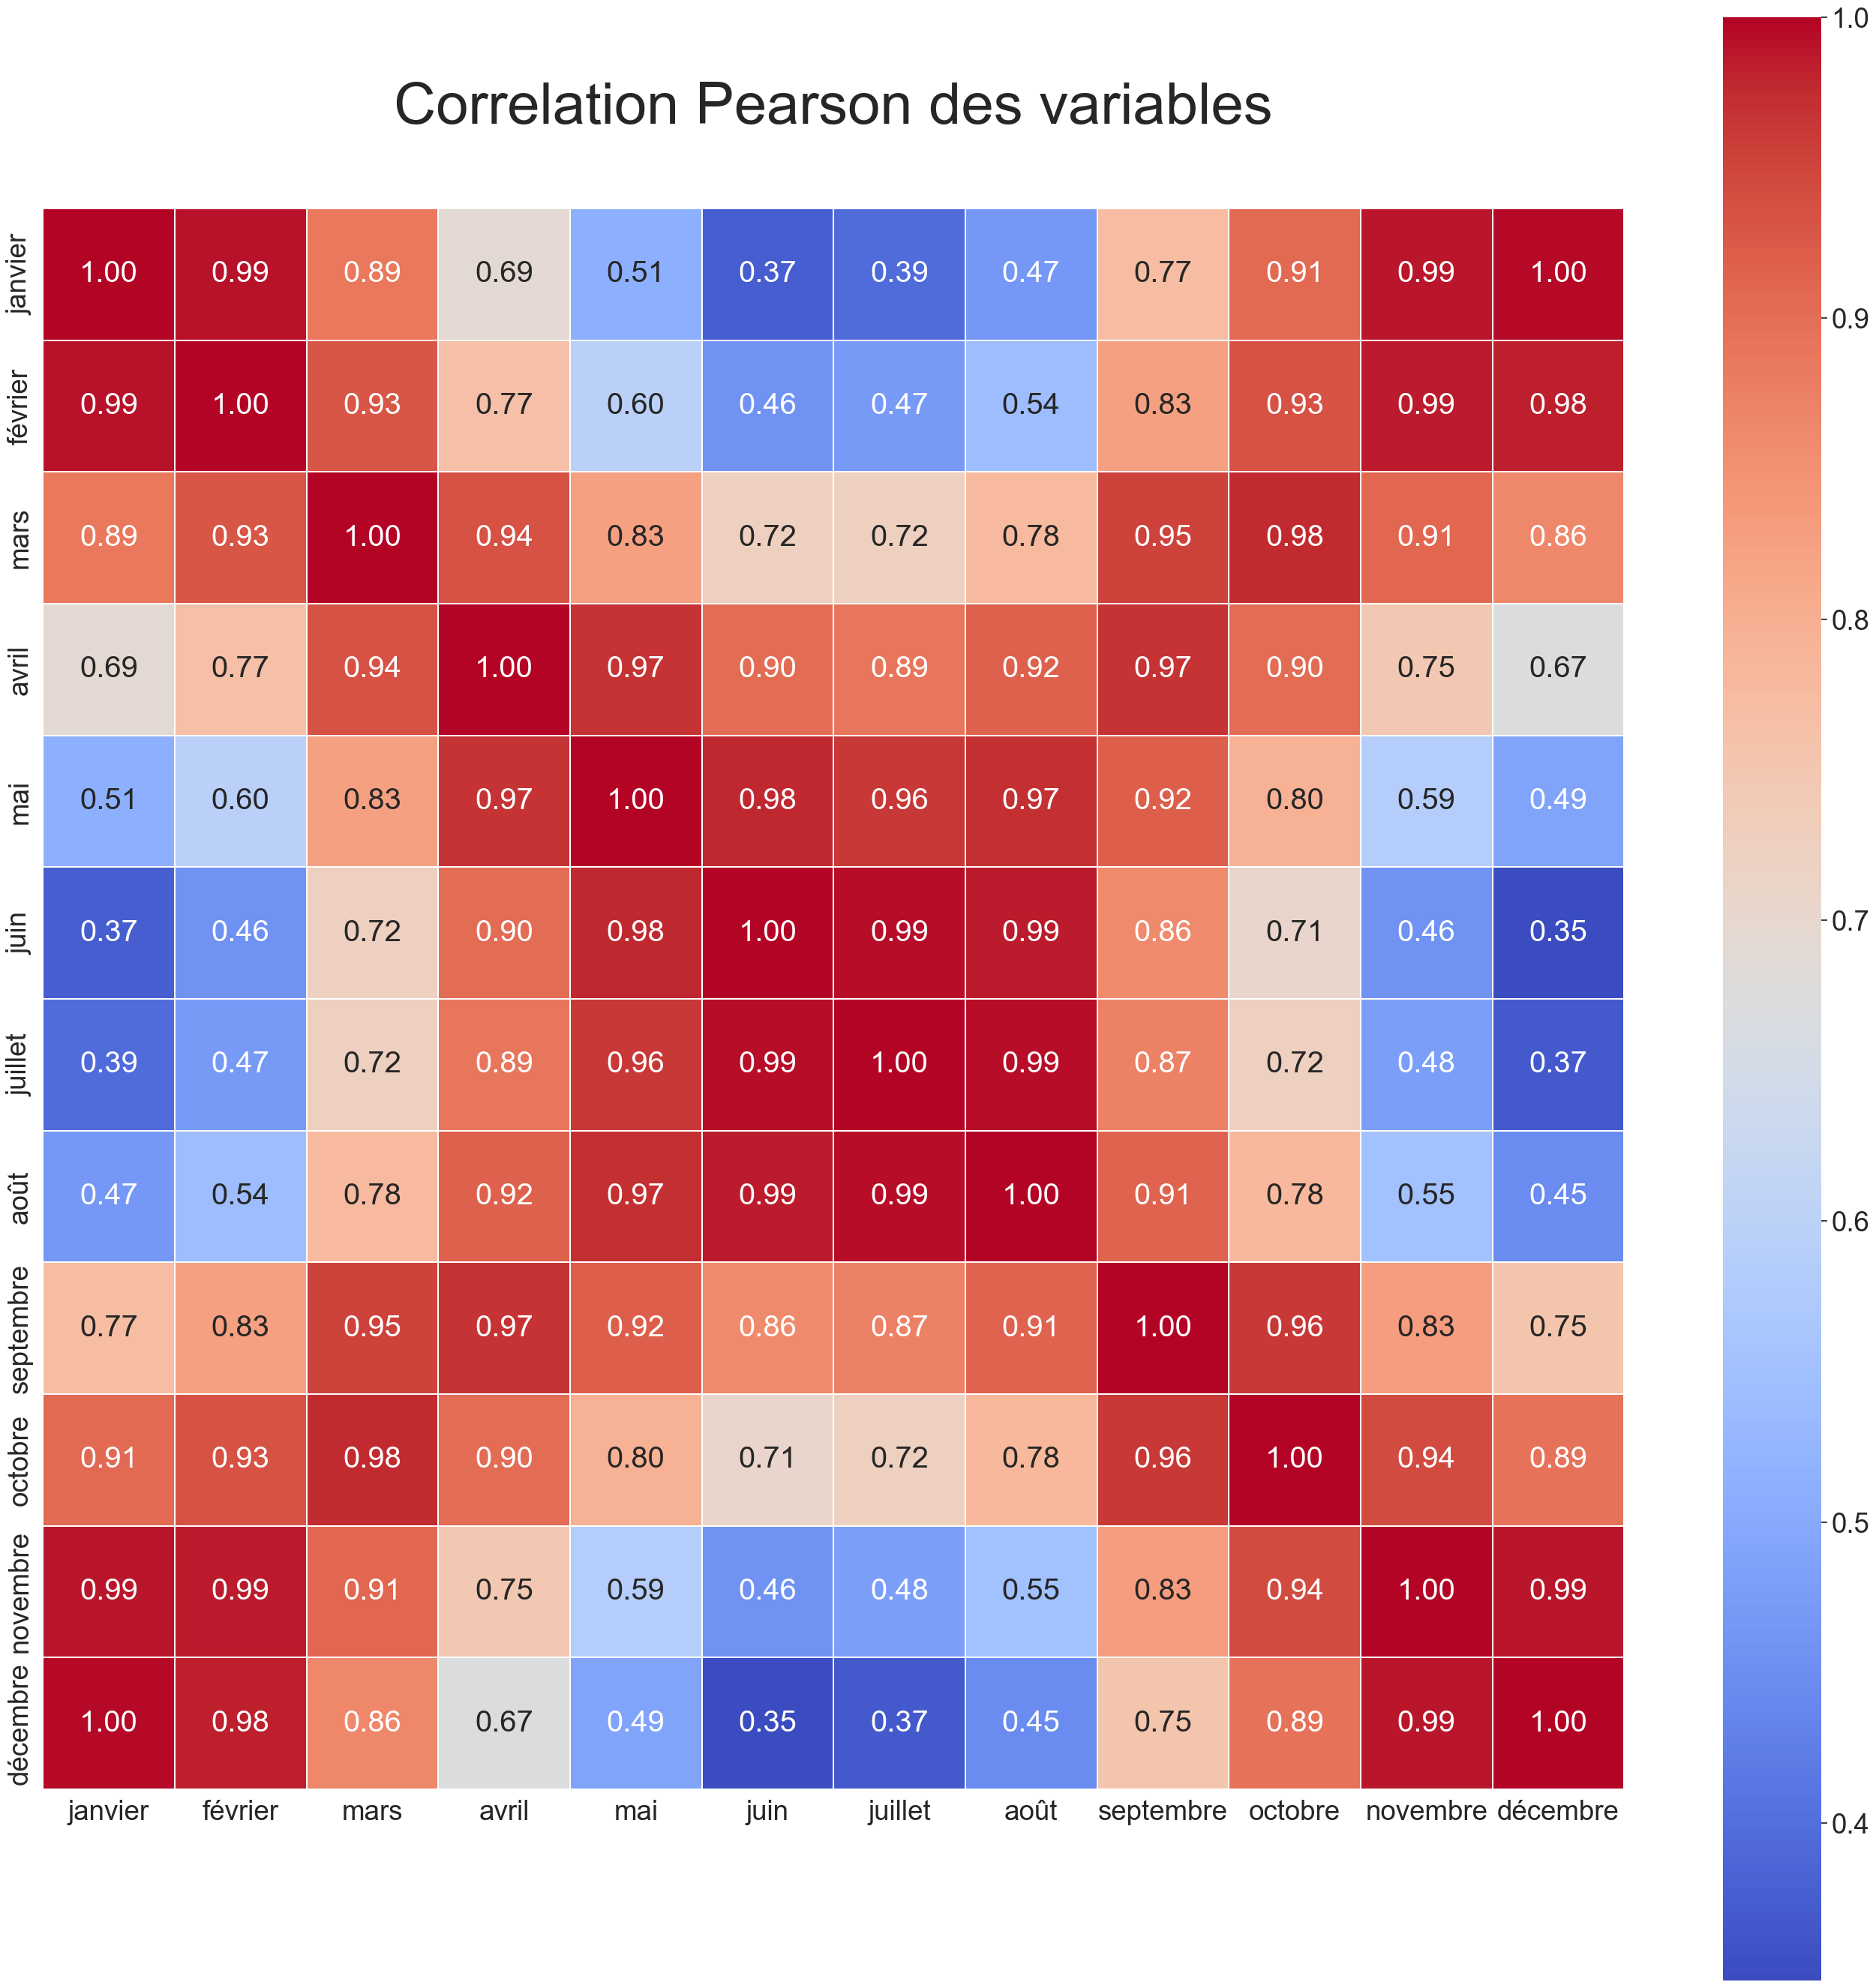

In [29]:
plt.figure(figsize=(34,34))
sns.set(font_scale=2.4)
plt.title('Correlation Pearson des variables', y=1.05, size=56)
sns.heatmap(temperatures.corr(),linewidths=0.3,vmax=1.0, fmt= '.2f', 
            square=True, cmap='coolwarm', linecolor='white', annot=True)
sauvegarderImage('Correlation Pearson des variables--Temperatures')
sns.set(font_scale=2)

# Centrage et réduction des données


<table>
<tr>
<th><img src="https://raw.githubusercontent.com/rbizoi/IntelligenceEnDonneesDeSante/refs/heads/main/images/moyenne.png"></th>
<th><img src="https://raw.githubusercontent.com/rbizoi/IntelligenceEnDonneesDeSante/refs/heads/main/images/ecart_type.png"></th>
<th><img src="https://raw.githubusercontent.com/rbizoi/IntelligenceEnDonneesDeSante/refs/heads/main/images/centrage_reduction.png"></th>
</tr>
</table>

In [30]:
modelStd = StandardScaler()
modelStd.fit(temperatures)
temperatures[['janvier', 'février', 'mars', 'avril', 'mai', 'juin', 'juillet', 'août',
              'septembre', 'octobre', 'novembre', 'décembre']] = modelStd.transform(temperatures)
temperatures.head()

,,,,,janvier,février,mars,avril,mai,juin,juillet,août,septembre,octobre,novembre,décembre
Nom,Latitude,Longitude,Altitude,Zone,,,,,,,,,,,,
Abbeville,50.136000,1.834000,69,NO,-0.467084,-0.483103,-0.882219,-1.016365,-1.175172,-1.305920,-1.228465,-1.126337,-0.937619,-0.796164,-0.500190,-0.430592
Ajaccio,41.918000,8.792667,5,SE,1.678445,1.592132,1.457332,1.435234,1.454125,1.390579,1.458143,1.564697,1.855513,1.963999,1.940572,1.762327
Alencon,48.445500,0.110167,143,NO,-0.429207,-0.516745,-0.758505,-0.849824,-0.840055,-0.822423,-0.815494,-0.860655,-0.896414,-0.848176,-0.562044,-0.489207
Bale,47.614333,7.510000,263,NE,-1.494694,-1.396539,-1.185783,-0.531535,-0.043166,0.086709,-0.141471,-0.283922,-0.885399,-1.195680,-1.356595,-1.450604
Bastia,42.540667,9.485167,10,SE,1.745129,1.701431,1.540025,1.525580,1.646642,1.627663,1.860589,1.981916,2.051744,1.938699,1.958185,1.830645


# Analyse en composantes principales

<table>
<tr>
<th><img src="https://raw.githubusercontent.com/rbizoi/IntelligenceEnDonneesDeSante/refs/heads/main/images/axe_variance_max.png"></th>
<th><img src="https://raw.githubusercontent.com/rbizoi/IntelligenceEnDonneesDeSante/refs/heads/main/images/max_dist.png"></th>
</tr>
</table>



In [31]:
modelPCA = PCA()
modelPCA.fit(temperatures)
modelPCA.explained_variance_ratio_.cumsum()*100

array([ 80.52130117,  98.73818778,  99.51865417,  99.75348574,
        99.86806878,  99.92399599,  99.9489883 ,  99.97040624,
        99.98819088,  99.99367652,  99.99708683, 100.        ])

## Choix du nombre des dimensions

In [32]:
sum(modelPCA.explained_variance_ratio_.cumsum()*100 <= 95) + 1

np.int64(2)

## Pourcentage d'inertie associée à chaque dimension

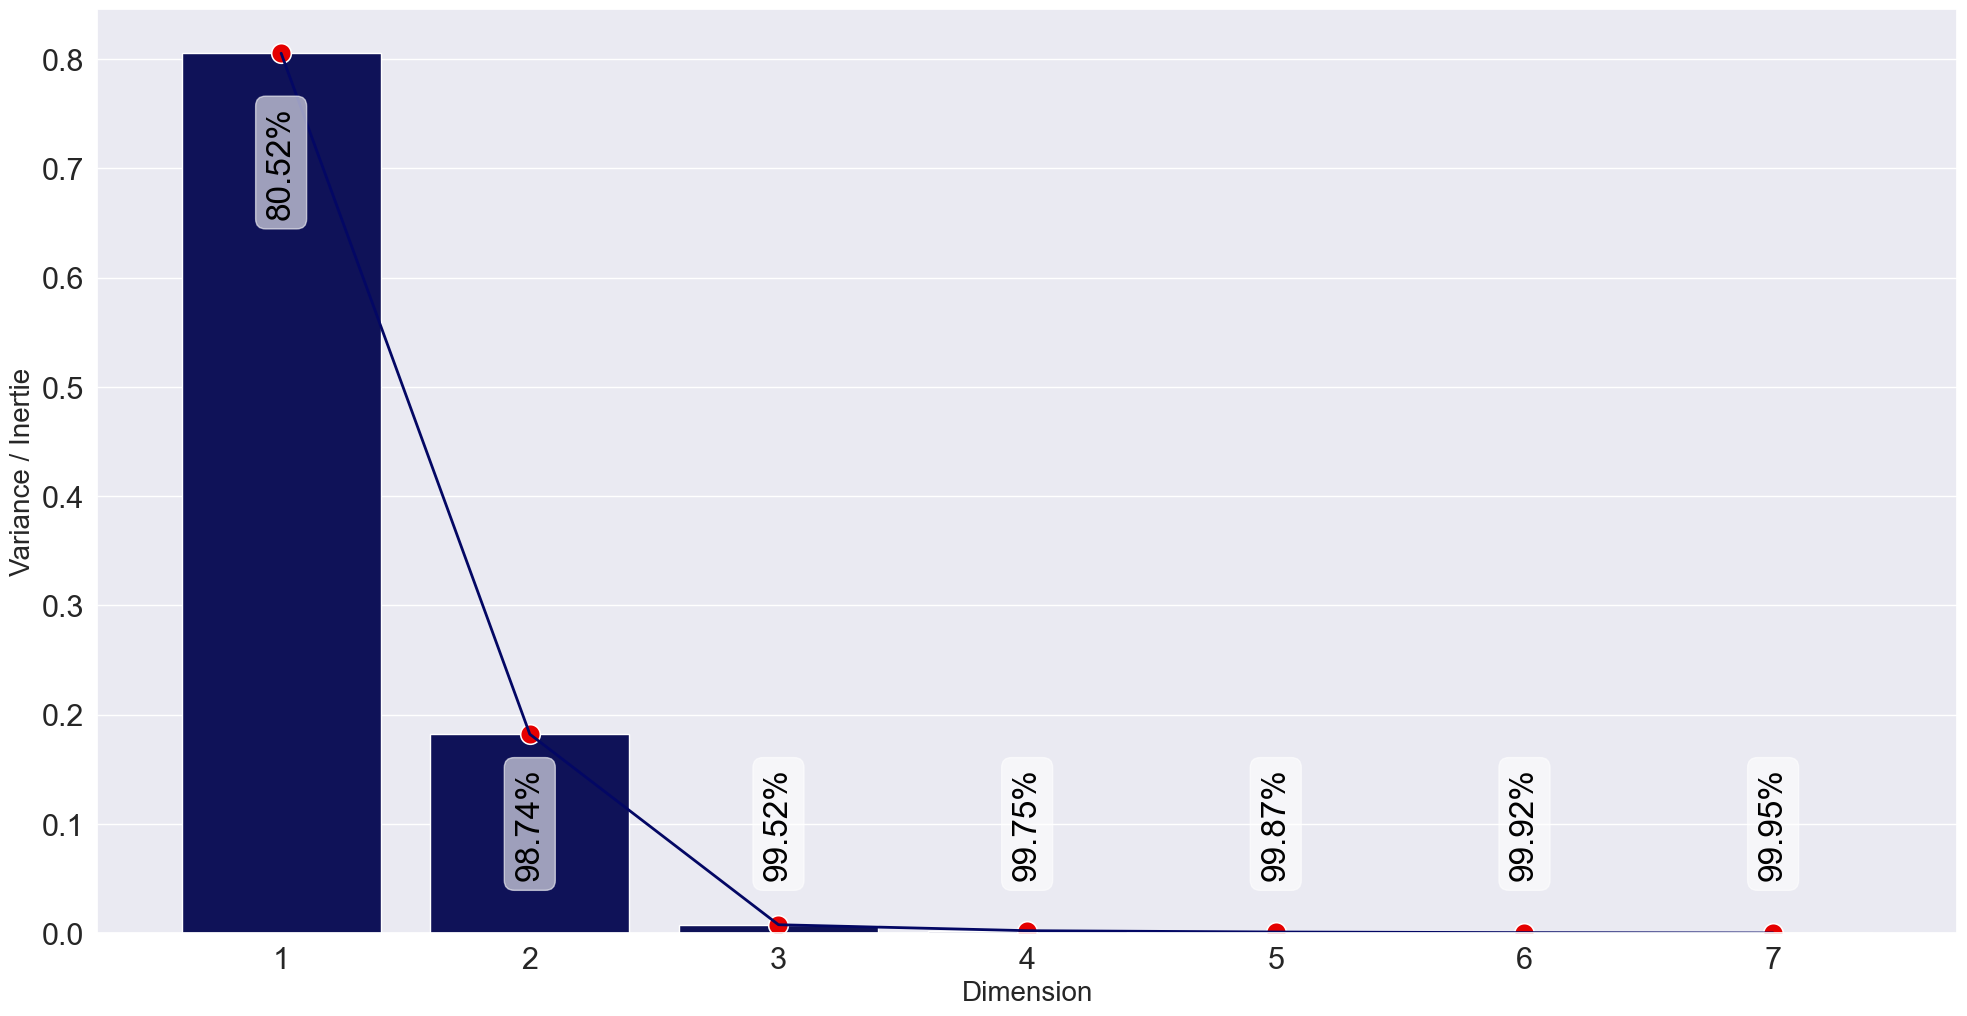

In [33]:
inertie = pd.DataFrame(modelPCA.explained_variance_ratio_,columns=['Inertie']) 
inertie['Label'] = np.round(modelPCA.explained_variance_ratio_.cumsum()*100,2)
inertie['Dimension'] = range(1,len(modelPCA.explained_variance_)+1)
# Affichage des 5 dimensions
dim = 7
inertie = inertie[inertie['Dimension']<= dim]

fig, ax = plt.subplots(figsize=(24,12));
graph = sns.barplot(x="Dimension",y='Inertie', data=inertie, color="#030764", ax=ax)

for i,(nom,valeur) in enumerate(zip(inertie.sort_values('Dimension').Label,inertie.sort_values('Dimension').Inertie)):
    valeur = 0.1 if valeur - 0.1 < 0.1 else valeur - 0.1
    delta =  i 
    graph.text(
                delta ,
                valeur,
                f'{nom}%',
                color='black',
                rotation='vertical',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.6),
                verticalalignment='center',
                horizontalalignment='center',
               )
    
graph = sns.lineplot( x=inertie.Dimension - 1,
                      y='Inertie',
                      data=inertie,
                      estimator = None, 
                      lw        = 2, 
                      ci        = None,
                      color     = "#030764",
                      ax    = ax);

sns.scatterplot(x=inertie.Dimension - 1,
                y     = 'Inertie',
                data  = inertie,
                s     = 200,
                # ci    = None, 
                color = "#e50000",
                ax    = ax);    
    
plt.xlabel('Dimension', fontproperties=font1)
plt.ylabel('Variance / Inertie', fontproperties=font1)

sauvegarderImage('Choix du nombre des dimensions--Temperatures')
plt.show()
sns.set(font_scale=2)

## Influence des variables dans les nouvelles dimensions

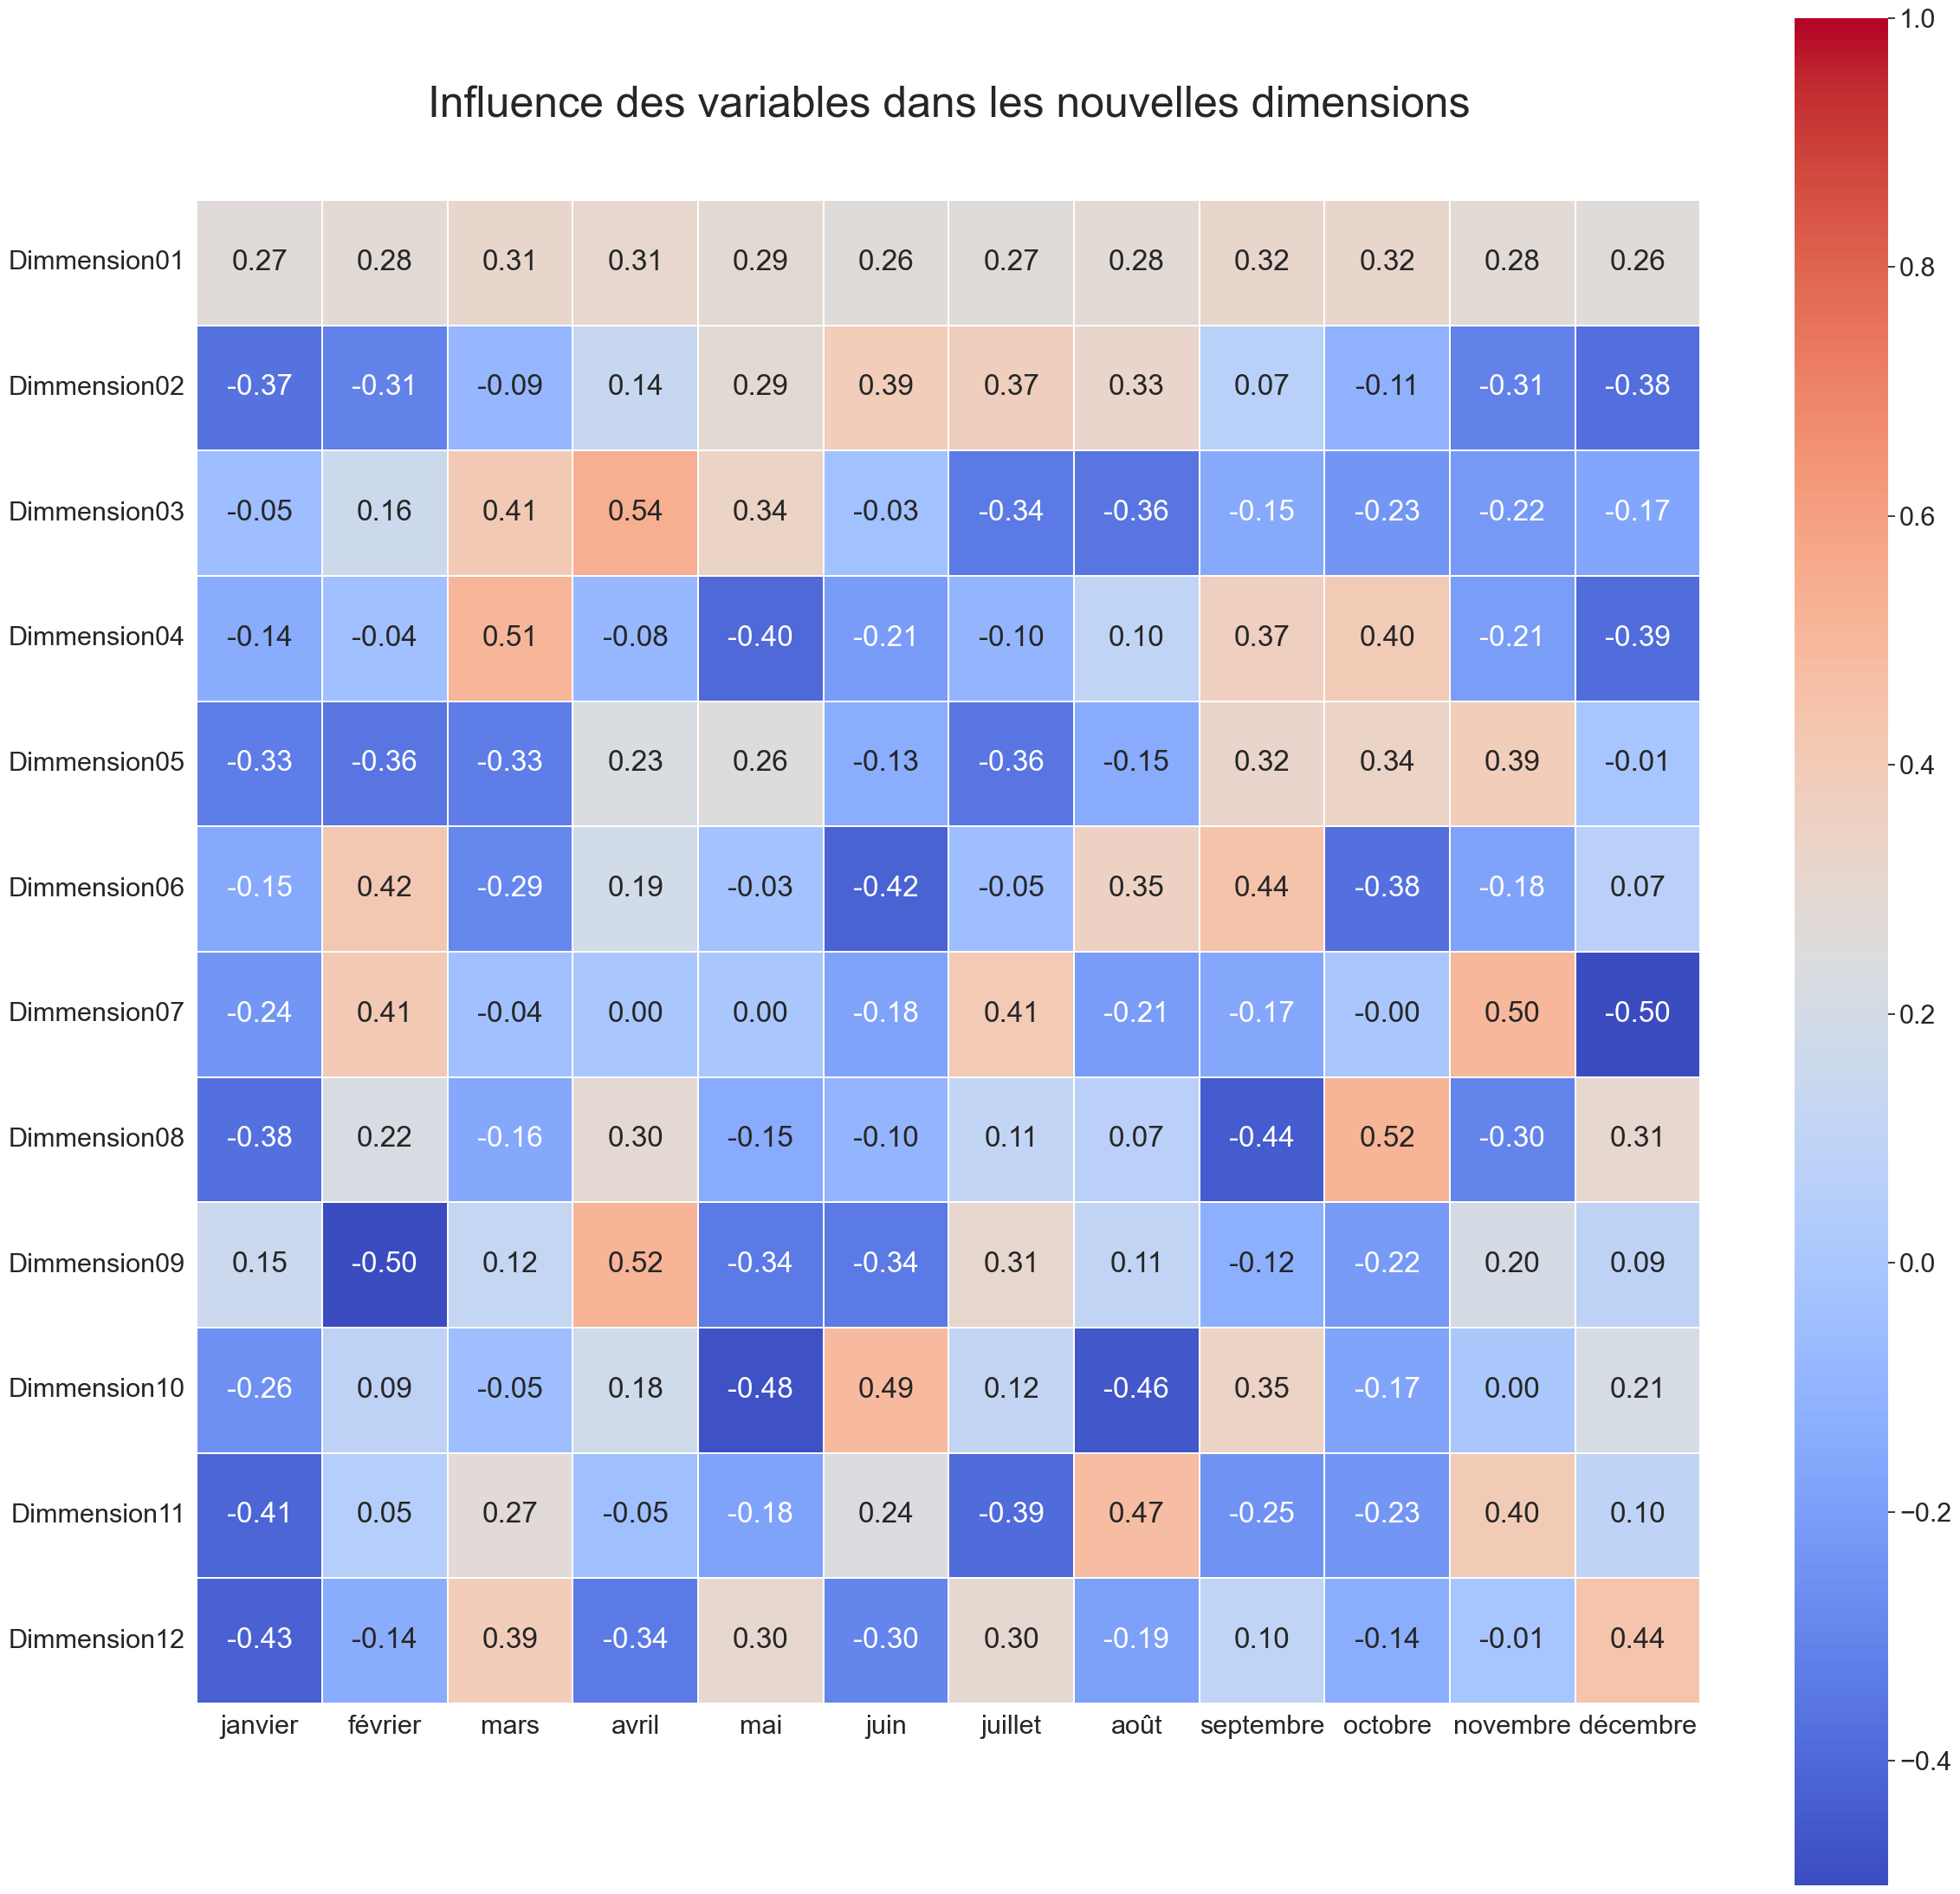

In [34]:
plt.figure(figsize=(28,28))
sns.set(font_scale=2)
plt.title("Influence des variables dans les nouvelles dimensions", y=1.05, size=36)
sns.heatmap(pd.DataFrame(modelPCA.components_, 
                         columns=temperatures.columns, 
                         index=[f'Dimmension{i:02d}' for i in range(1,13)]),
            fmt= '.2f',linewidths=0.3,vmax=1.0, 
            square=True, cmap='coolwarm', linecolor='white', annot=True);
sauvegarderImage('Influence des variables dans les nouvelles dimensions--Temperatures')

## Transformation des données 

In [35]:
n_components = sum(modelPCA.explained_variance_ratio_.cumsum() < .95 ) + 1 
modelPCA = PCA(n_components=n_components)
x_proj = modelPCA.fit_transform(temperatures)
donnees2d = pd.DataFrame(x_proj, index=temperatures.index, columns=[f'Dimension{i:02d}' for i in range(1,n_components+1)])

In [36]:
n_components=3
modelPCA = PCA(n_components=n_components)
x_proj = modelPCA.fit_transform(temperatures)
donnees3d = pd.DataFrame(x_proj, index=temperatures.index, columns=[f'Dimension{i:02d}' for i in range(1,n_components+1)])

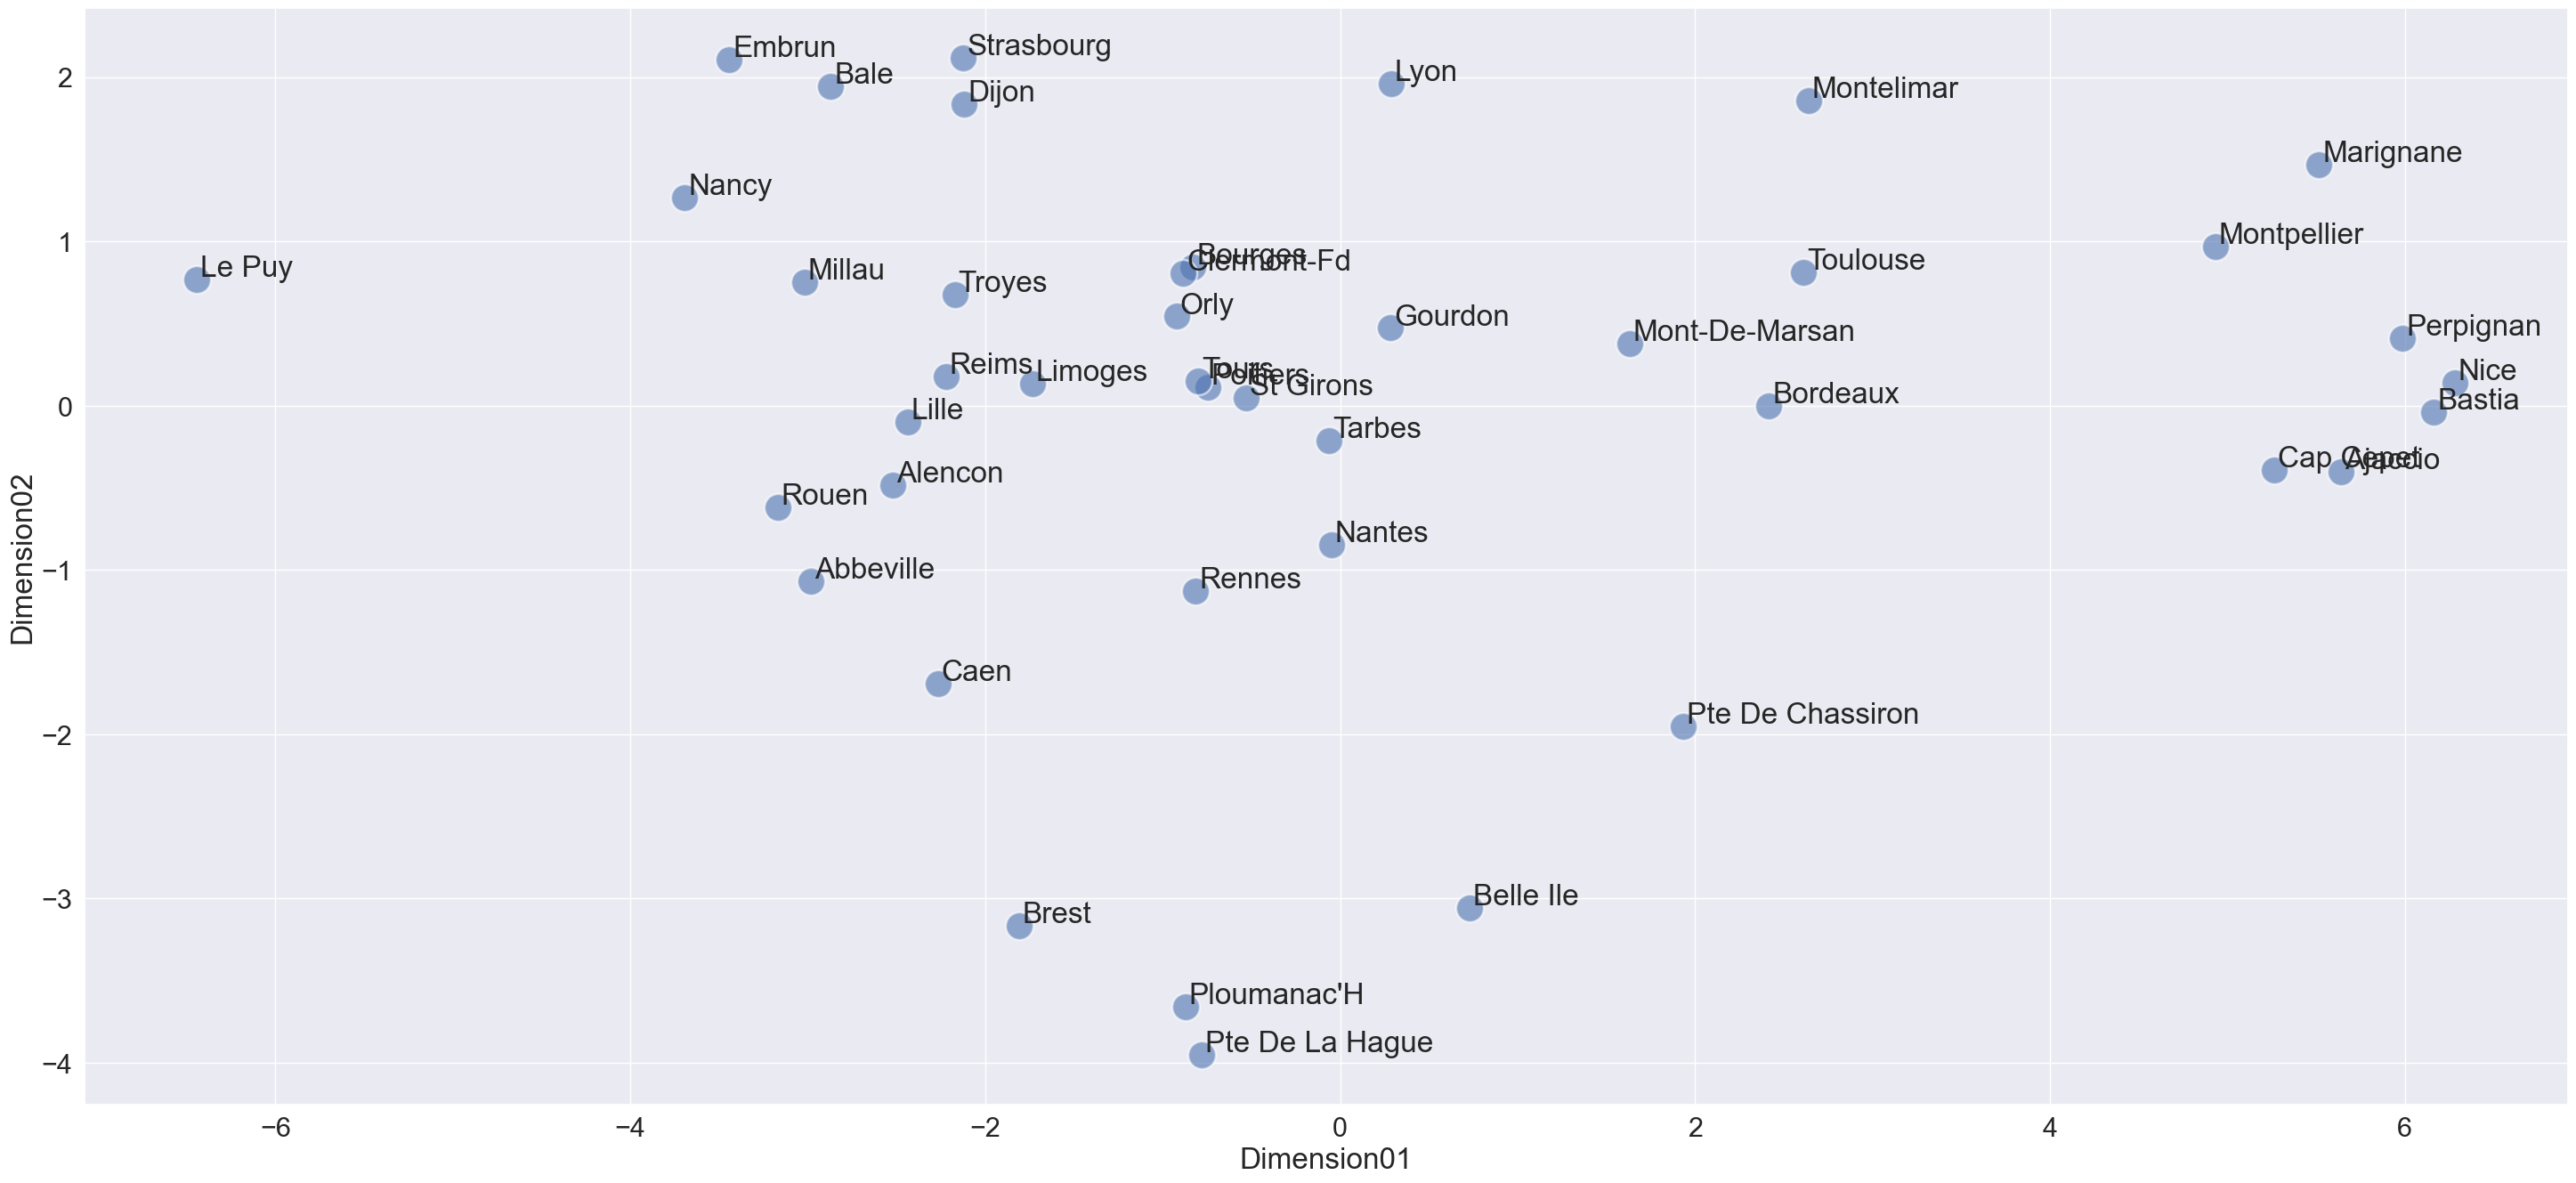

In [37]:
fig, ax = plt.subplots(figsize=(36,16));

affichage = donnees2d.reset_index()
sns.scatterplot(x       = 'Dimension01', 
                y       = 'Dimension02',
                # size    = 'Altitude', 
                # hue     = 'Zone', 
                data    = affichage,
                s       = 500,
                palette = palette,
                alpha=0.6,
                ax=ax
                );

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y']+.02, str(point['val']), fontproperties=font2, rotation=0)

label_point(affichage.Dimension01, affichage.Dimension02, affichage.Nom, ax)        
# sauvegarderImage('Influence des variables dans les nouvelles dimensions--Temperatures')

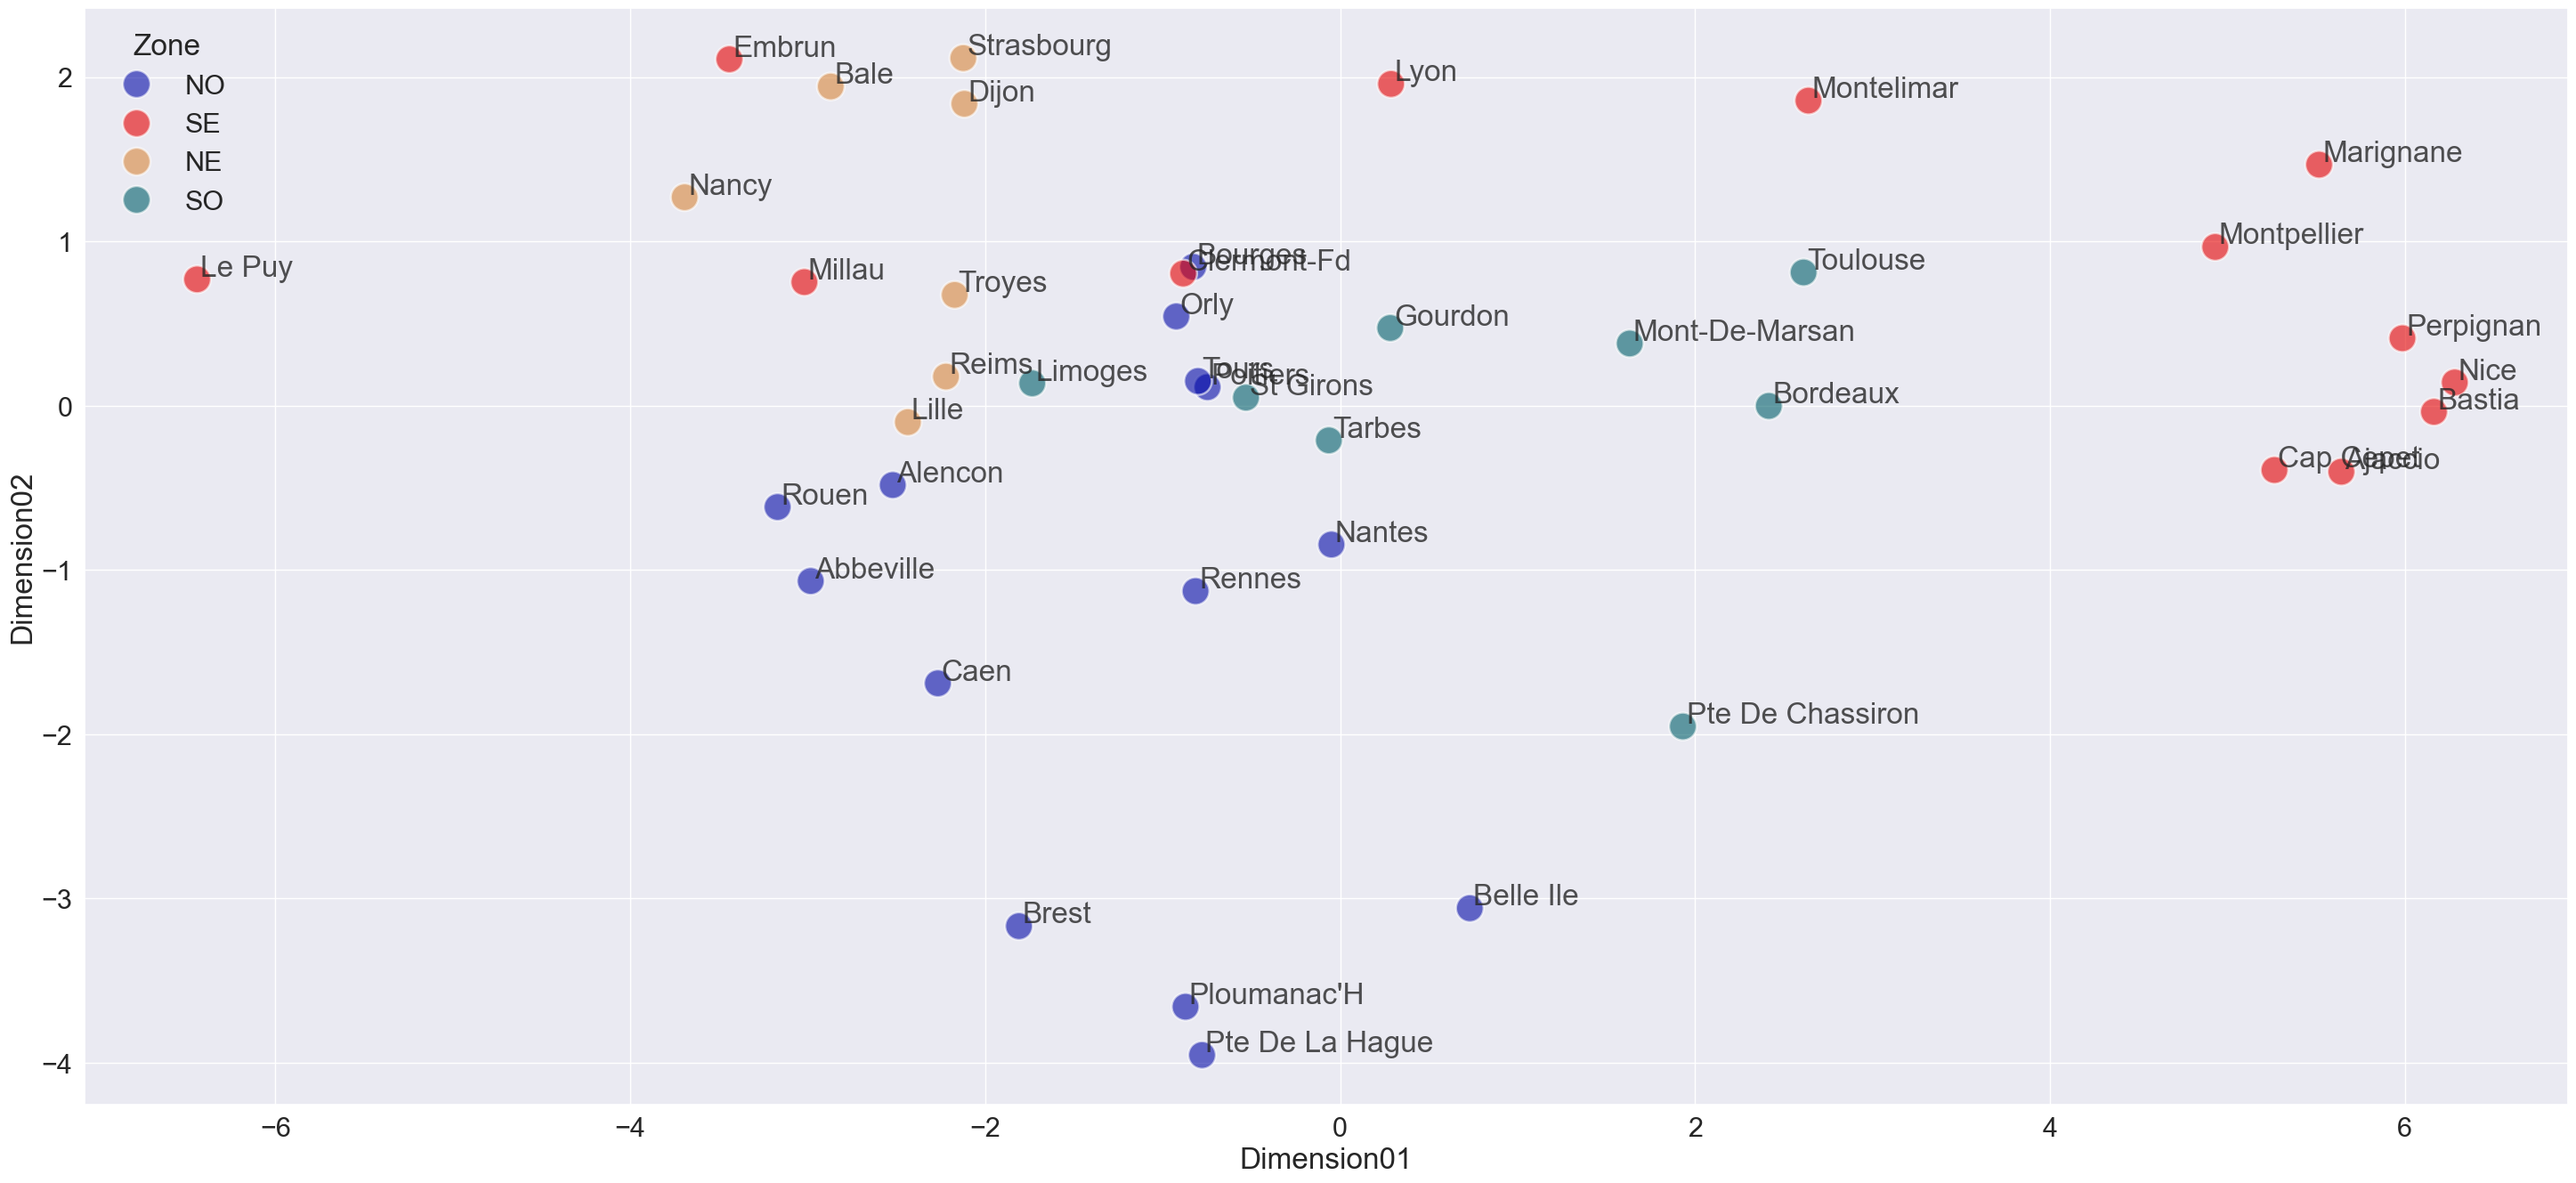

In [38]:
fig, ax = plt.subplots(figsize=(36,16));

affichage = donnees2d.reset_index()
sns.scatterplot(x       = 'Dimension01', 
                y       = 'Dimension02',
                # size    = 'Altitude', 
                hue     = 'Zone', 
                data    = affichage,
                s       = 500,
                palette = palette,
                alpha=0.6,
                ax=ax
                );

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y']+.02, str(point['val']), alpha=0.8, fontproperties=font2, rotation=0)

label_point(affichage.Dimension01, affichage.Dimension02, affichage.Nom, ax)        
# sauvegarderImage('Influence des variables dans les nouvelles dimensions--Temperatures')

In [39]:
layout = go.Layout({"showlegend": False})

fig = px.scatter_3d(donnees3d.reset_index(), 
                    x='Dimension01', 
                    y='Dimension02', 
                    z='Dimension03',
                    color='Zone',
#                     size=100+donnees3d.reset_index().Altitude,
#                     symbol=donnees.CD23.cat.codes,
                    text='Nom',
                    width=1024,
                    height=1024,
                   )

fig.show()

In [40]:
fig = px.scatter( donnees2d.reset_index(), 
                  x='Dimension01', 
                  y='Dimension02', 
                  color='Zone',
                  size=donnees2d.reset_index().Altitude,
                  symbol=donnees2d.reset_index().Zone,
                  text='Nom',
                  width=1024,
                  height=512,
                  )

fig.show()

# Classification hiérarchique ascendante

In [41]:
Villes = donnees2d.reset_index().Nom.values
donnees2d.head()

,,,,,Dimension01,Dimension02
Nom,Latitude,Longitude,Altitude,Zone,,
Abbeville,50.136000,1.834000,69,NO,-2.983567,-1.067123
Ajaccio,41.918000,8.792667,5,SE,5.642383,-0.401873
Alencon,48.445500,0.110167,143,NO,-2.521222,-0.482706
Bale,47.614333,7.510000,263,NE,-2.870625,1.943435
Bastia,42.540667,9.485167,10,SE,6.164186,-0.037249


## Calcul des arbres 

In [42]:
def afficheDendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Classification Hiérarchique Ascendante')
        plt.xlabel('Villes ou (taille du cluster)')
        plt.ylabel('Distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [43]:
Z = linkage(donnees2d, 'ward')

## Affichage des arbres

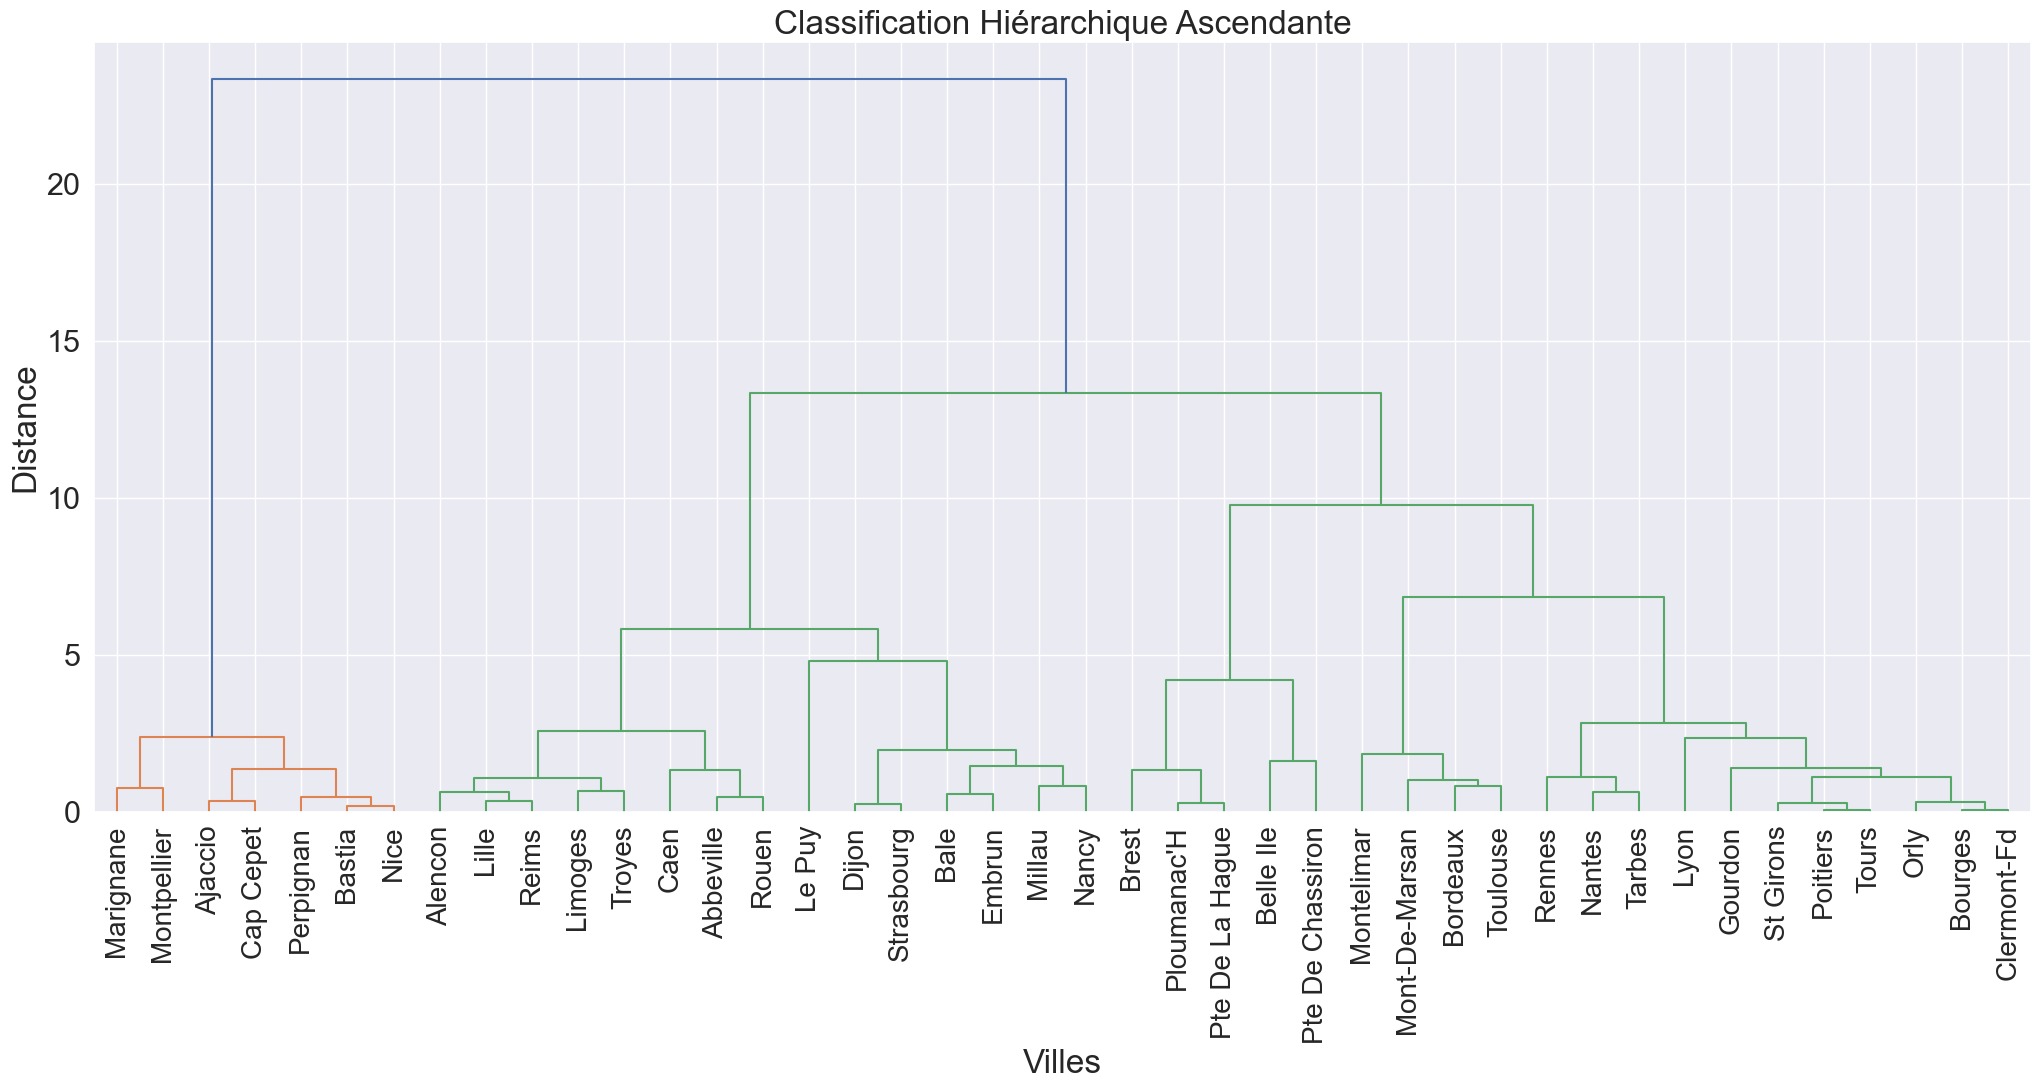

In [44]:
plt.figure(figsize=(25, 10))
plt.title('Classification Hiérarchique Ascendante')
plt.xlabel('Villes')
plt.ylabel('Distance')
dendrogram( Z,leaf_rotation=90.,leaf_font_size=20.,
           labels = Villes)
plt.show()

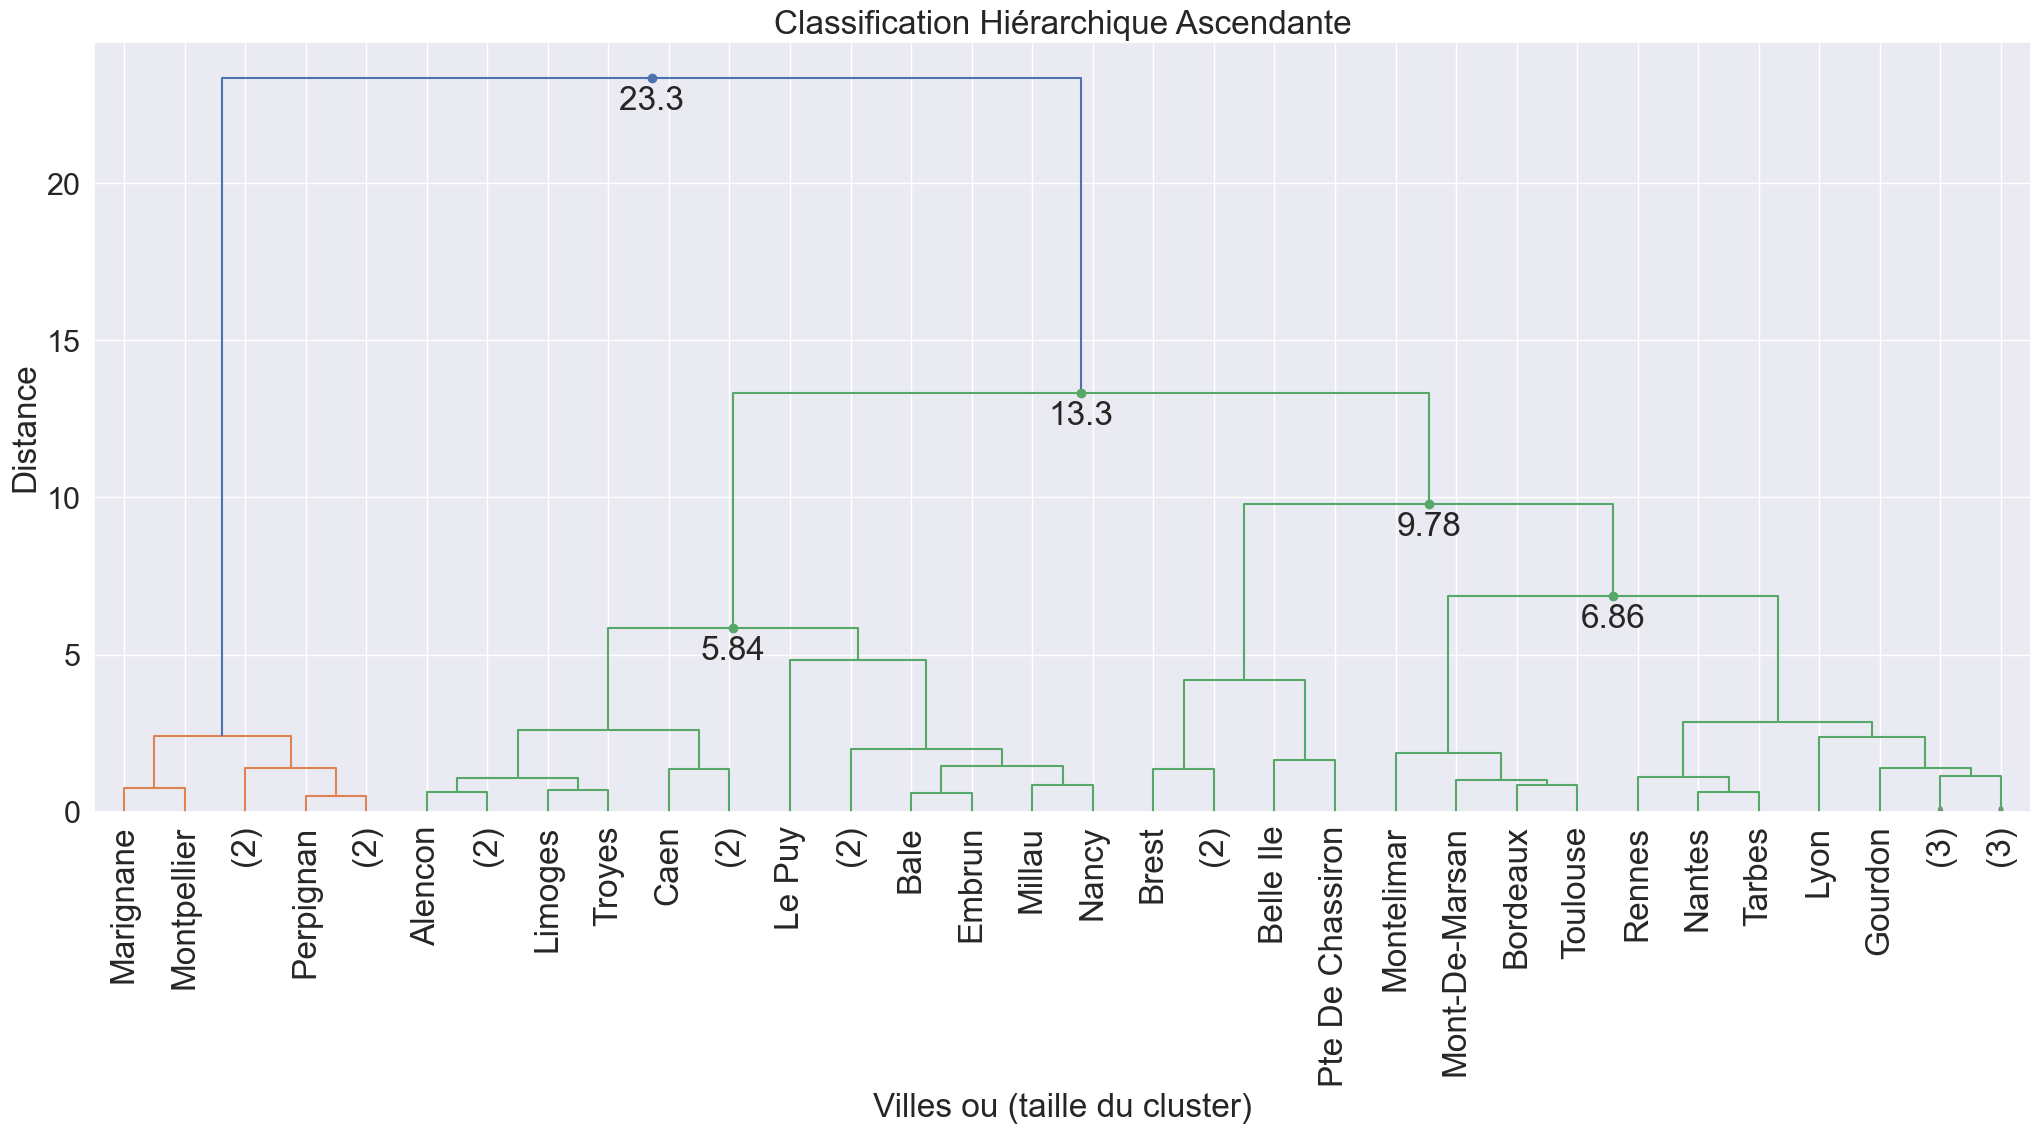

In [45]:
plt.figure(figsize=(25, 10))
afficheDendrogram(
    Z,
    truncate_mode='lastp',
    p=32,                  # nombres des classes
    leaf_rotation=90.,
    leaf_font_size=24.,
    show_contracted=True,
    annotate_above=5,      # les annotations à partir de cette distance
    labels = Villes
)
plt.show()

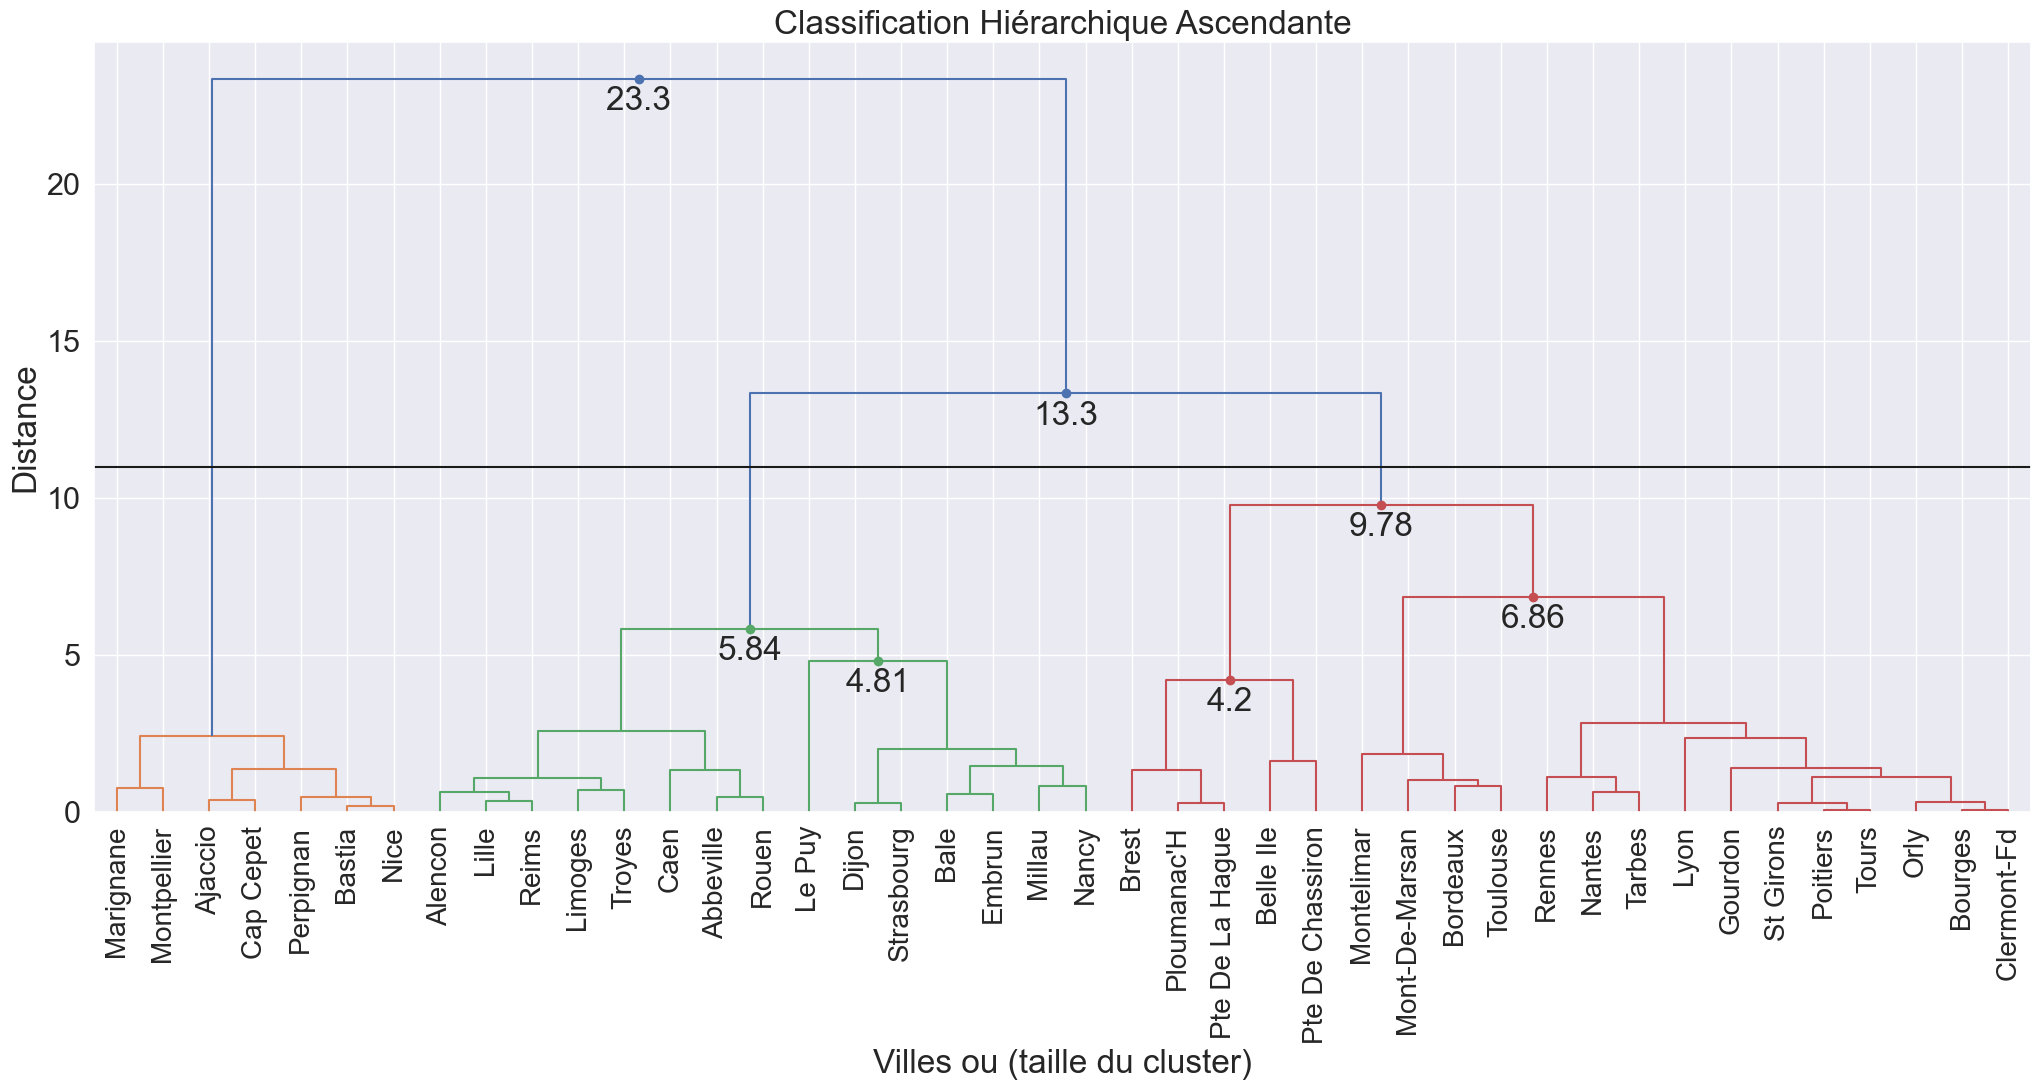

In [46]:
plt.figure(figsize=(25, 10))
afficheDendrogram(
    Z,
    truncate_mode='lastp',
    p=42,                          # nombres des classes
    leaf_rotation=90.,
    leaf_font_size=20.,
    show_contracted=True,
    annotate_above=4,              # les annotations à partir de cette distance
    max_d=11,                      # la distance de découpage de l’arbre
    labels = Villes
)
plt.show()

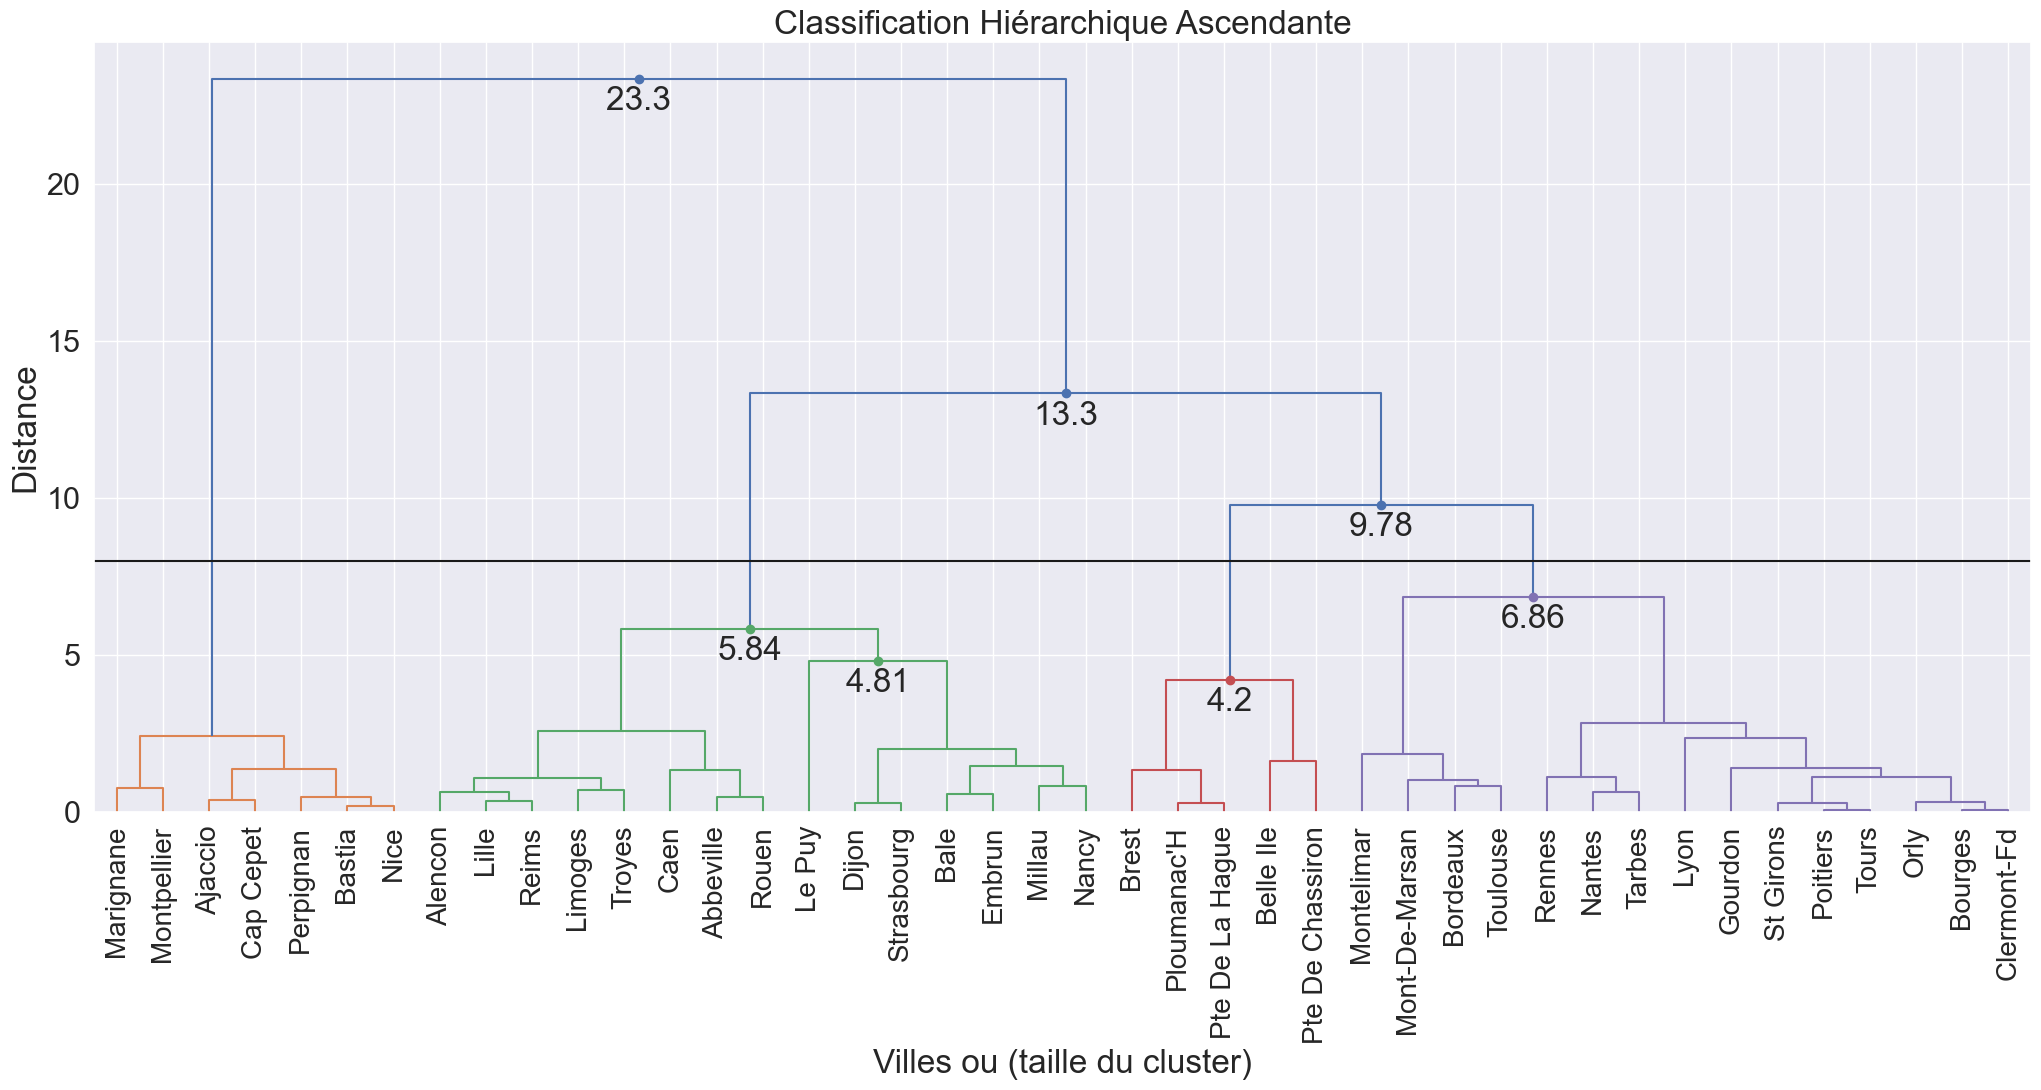

In [47]:
plt.figure(figsize=(25, 10))
afficheDendrogram(
    Z,
    truncate_mode='lastp',
    p=42,                          # nombres des classes
    leaf_rotation=90.,
    leaf_font_size=20.,
    show_contracted=True,
    annotate_above=4,              # les annotations à partir de cette distance
    max_d=8,                       # la distance de découpage de l’arbre
    labels = Villes
)
plt.show()

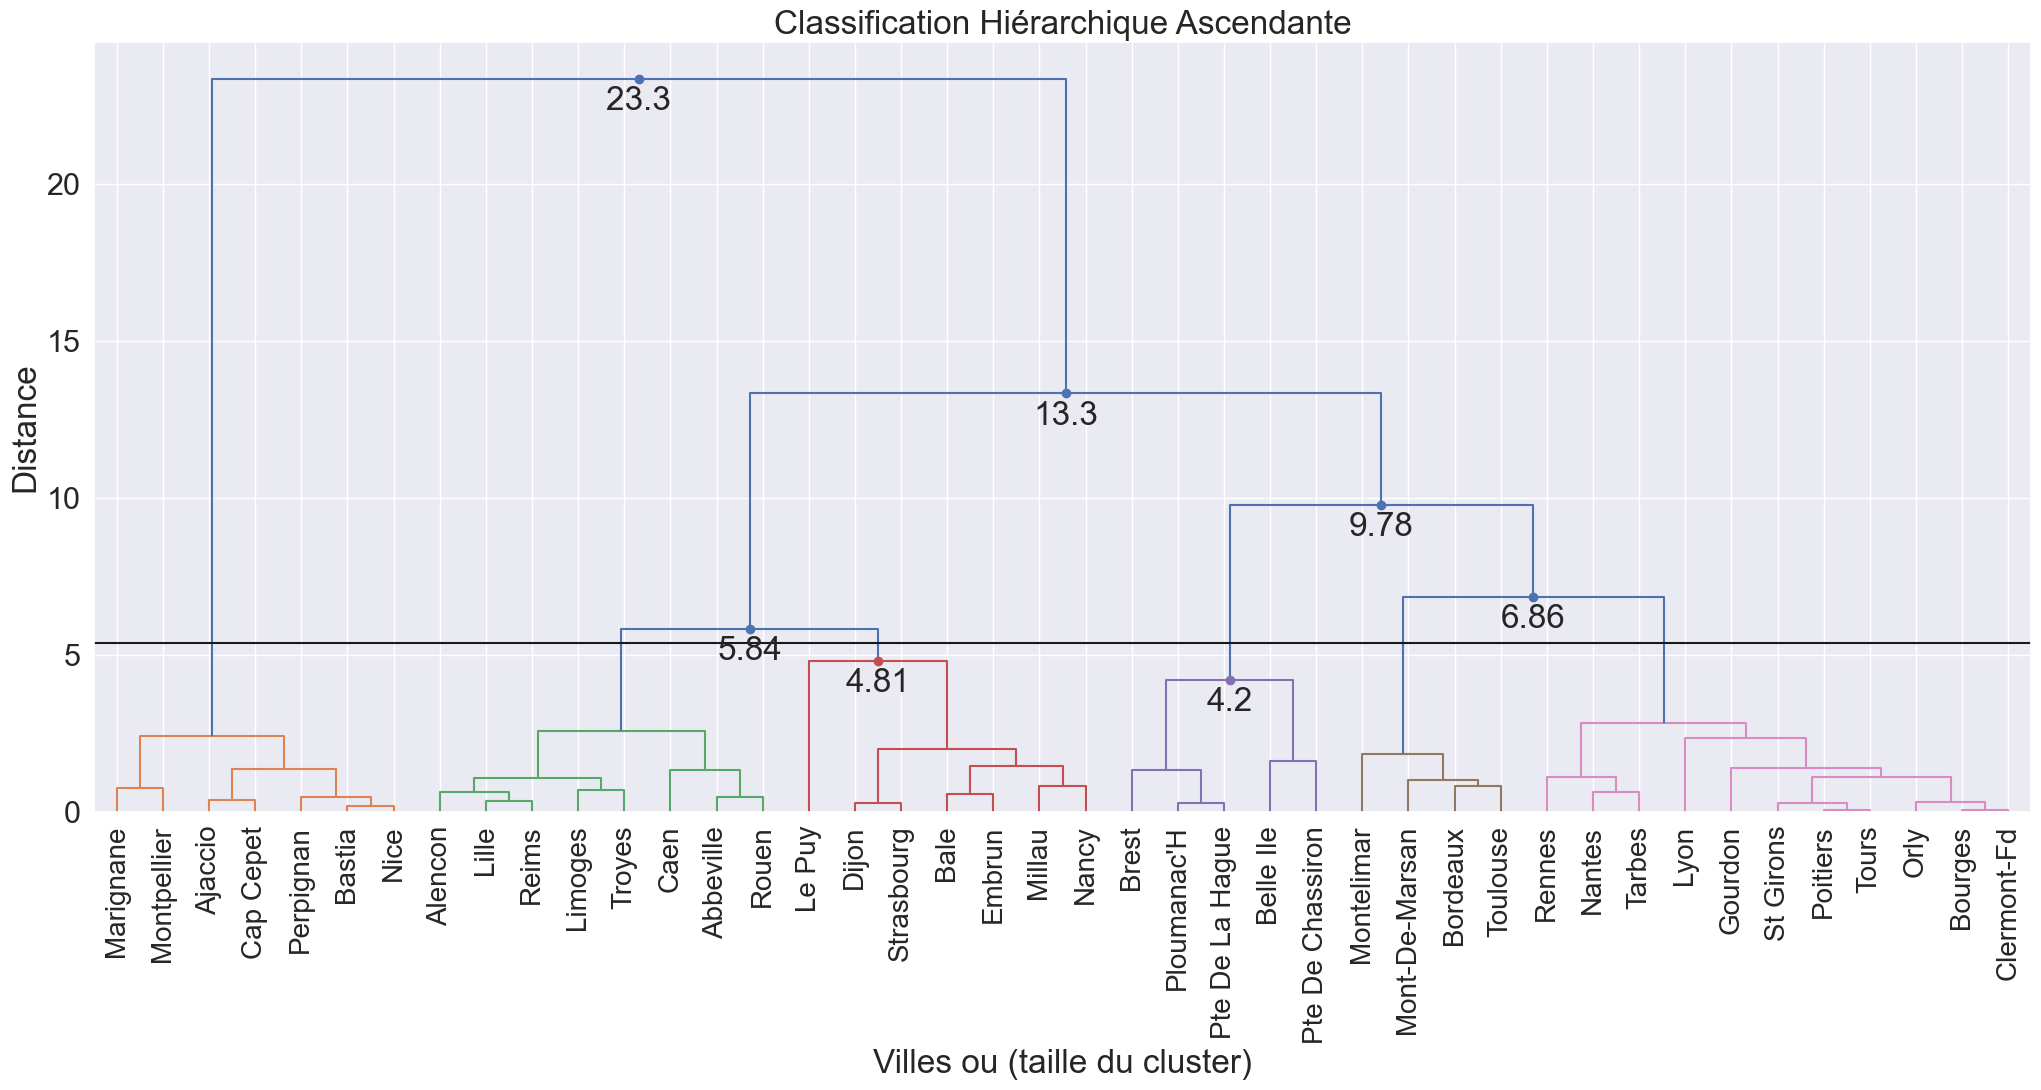

In [48]:
plt.figure(figsize=(25, 10))
afficheDendrogram(
    Z,
    truncate_mode='lastp',
    p=42,                          # nombres des classes
    leaf_rotation=90.,
    leaf_font_size=20.,
    show_contracted=True,
    annotate_above=4,              # les annotations à partir de cette distance
    max_d=5.4,                     # la distance de découpage de l’arbre
    labels = Villes
)
plt.show()

## Prédiction des classes

In [49]:
donnees2d['Classes6']=fcluster(Z, t=5.4, criterion='distance')
donnees2d['Classes4']=fcluster(Z, t=8, criterion='distance')
donnees2d['Classes3']=fcluster(Z, t=11, criterion='distance')

In [50]:
donnees2d.reset_index()

,Nom,Latitude,Longitude,Altitude,Zone,Dimension01,Dimension02,Classes6,Classes4,Classes3
0,Abbeville,50.136000,1.834000,69,NO,-2.983567,-1.067123,2,2,2
1,Ajaccio,41.918000,8.792667,5,SE,5.642383,-0.401873,1,1,1
2,Alencon,48.445500,0.110167,143,NO,-2.521222,-0.482706,2,2,2
3,Bale,47.614333,7.510000,263,NE,-2.870625,1.943435,3,2,2
4,Bastia,42.540667,9.485167,10,SE,6.164186,-0.037249,1,1,1
5,Belle Ile,47.294333,-3.218333,34,NO,0.730641,-3.058764,4,3,3
6,Bordeaux,44.830667,-0.691333,47,SO,2.415865,-0.001210,5,4,3
7,Bourges,47.059167,2.359833,161,NO,-0.828217,0.845296,6,4,3
8,Brest,48.444167,-4.412000,94,NO,-1.810130,-3.167722,4,3,3
9,Caen,49.180000,-0.456167,67,NO,-2.267194,-1.689485,2,2,2


## Affichage des clusters 

In [51]:
fig = px.scatter(donnees2d.reset_index(), 
                    x='Dimension01', 
                    y='Dimension02', 
                    color='Classes3',
                    text='Nom',
                    size='Classes3',
                    width=1024,
                    height=512,
                    opacity=0.4,
                   )

fig.show()

In [52]:
fig = px.scatter(donnees2d.reset_index(), 
                    x='Dimension01', 
                    y='Dimension02', 
                    color='Classes4',
                    text='Nom',
                    size='Classes4',
                    width=1024,
                    height=512,
                    opacity=0.4,
                   )

fig.show()

In [53]:
fig = px.scatter(donnees2d.reset_index(), 
                    x='Dimension01', 
                    y='Dimension02', 
                    color='Classes6',
                    text='Nom',
                    size='Classes6',
                    width=1024,
                    height=512,
                    opacity=0.4,
                   )

fig.show()

# Clustering non hiérarchique

In [54]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(donnees2d.values)
y_kmeans = kmeans.predict(donnees2d.values)
donnees2d['Km3'] = y_kmeans+1
kmeans = KMeans(n_clusters=4)
kmeans.fit(donnees2d.values)
y_kmeans = kmeans.predict(donnees2d.values)
donnees2d['Km4'] = y_kmeans+1
kmeans = KMeans(n_clusters=6)
kmeans.fit(donnees2d.values)
y_kmeans = kmeans.predict(donnees2d.values)
donnees2d['Km6'] = y_kmeans+1

In [55]:
donnees2d.head()

,,,,,Dimension01,Dimension02,Classes6,Classes4,Classes3,Km3,Km4,Km6
Nom,Latitude,Longitude,Altitude,Zone,,,,,,,,
Abbeville,50.136000,1.834000,69,NO,-2.983567,-1.067123,2,2,2,2,3,5
Ajaccio,41.918000,8.792667,5,SE,5.642383,-0.401873,1,1,1,1,1,1
Alencon,48.445500,0.110167,143,NO,-2.521222,-0.482706,2,2,2,2,3,5
Bale,47.614333,7.510000,263,NE,-2.870625,1.943435,3,2,2,2,3,2
Bastia,42.540667,9.485167,10,SE,6.164186,-0.037249,1,1,1,1,1,1


In [56]:
fig = px.scatter(donnees2d.reset_index(), 
                    x='Dimension01', 
                    y='Dimension02', 
                    color='Km3',
                    text='Nom',
                    size='Km3',
                    width=1024,
                    height=512,
                    opacity=0.4,
                   )

fig.show()

In [57]:
fig = px.scatter(donnees2d.reset_index(), 
                    x='Dimension01', 
                    y='Dimension02', 
                    color='Km4',
                    text='Nom',
                    size='Km4',
                    width=1024,
                    height=512,
                    opacity=0.4,
                   )

fig.show()

In [58]:
fig = px.scatter(donnees2d.reset_index(), 
                    x='Dimension01', 
                    y='Dimension02', 
                    color='Km6',
                    text='Nom',
                    size='Km6',
                    width=1024,
                    height=512,
                    opacity=0.4,
                   )

fig.show()